In [1]:
from Pyhough import Funcs

In [2]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm.notebook import tqdm
from time import sleep
import scipy
from pykuwahara import kuwahara
import math
from scipy import ndimage
import seaborn as sns
from scipy.interpolate import interp2d


def importimagemhd(path):
    """Gets and prints the spreadsheet's header columns

    Parameters
    ----------
    file_loc : str
        The file location of the spreadsheet
    print_cols : bool, optional
        A flag used to print the columns to the console (default is
        False)

    Returns
    -------
    list
        a list of strings used that are the header columns
    """
    
    scan= sitk.GetArrayFromImage(sitk.ReadImage(path,sitk.sitkFloat32))
    hitsplot=scan[0]
    #plt.imshow(hitsplot,cmap="gray")
    return hitsplot

def negative(fig):
    """Returns negative of the image

    Parameters
    ----------
    fig : Array
        Image intensity pixel array
    
    Returns
    -------
    newfig
        processed array
    """
    newfig=np.copy(fig)
    maxint=np.max(fig)
    
    print(maxint)
    for i in range(len(fig)):
        for j in range(len(fig[i])):
            newfig[i][j]=maxint-fig[i][j]
    return newfig

def subdivide(fig,intensity):
    """Return image with an intensity cut, every value under a threshold
    is converted to a np.nan value, which can also be translated to zero,
    every value over threshold preserves original value

    Parameters
    ----------
    fig : Array
        Image intensity pixel array
        
    intensity : int
        threshold value
    
    Returns
    -------
    newfig
        processed array
    """
    newfig=np.zeros(np.shape(fig))
    #print(fig)
    for i in range(len(fig)):
        for j in range(len(fig[i])):
            if fig[i][j] <= intensity:
                newfig[i][j]=np.nan
            if fig[i][j] > intensity:
                newfig[i][j]=fig[i][j]
    return newfig

def threshold(fig,intensity):
    """Return image with an intensity cut, every value under a threshold
    is converted to  zero, every value over threshold is updated to thld

    Parameters
    ----------
    fig : Array
        Image intensity pixel array
        
    intensity : int
        threshold value
    
    Returns
    -------
    newfig
        processed array
    """
    newfig=np.zeros(np.shape(fig))
    #print(fig)
    for i in range(len(fig)):
        for j in range(len(fig[i])):
            if fig[i][j] <= intensity:
                newfig[i][j]=0
            if fig[i][j] > intensity:
                newfig[i][j]=intensity
    return newfig

def edges(img):
    """Return image edges by canny edge processing

    Parameters
    ----------
    img : Array
        Image intensity pixel array
    
    Returns
    -------
    edgesret
        image with edges
    """
    slice1Copy = np.uint16(img)
    #edgearray=np.zeros(np.shape(img))
    edgesret = cv2.Canny(np.asarray(slice1Copy),100,200)
    #plt.imshow(edgesret,cmap = 'gray')
    return edgesret


def recolor(img,param1=4,longs=1,intens=100):
    """Return image using local recolor selection, if param1 pixels
    in manhattan viccinity of maximum value longs is less than intens,
    pixel becomes zero, else preserves its value

    Parameters
    ----------
    img : Array
        Image intensity pixel array
        
    param1 : minumum value to count pixel
        threshold value
        
        intensity : int
        threshold value
    
    Returns
    -------
    newfig
        processed array
    """
    
    newfig=np.zeros(np.shape(img))
    width,height= np.shape(newfig)
    print(height,width)
    for i in range(longs,width-longs):
        for j in range(longs,height-longs):
            if img[i][j]>intens:
                        counter=0
                        for k in range(1,longs+1): 
                            if img[i+k][j]>intens:
                                counter+=1
                            if img[i+k][j+k]>intens:
                                counter+=1
                                
                            if img[i+k][j-k]>intens:
                                counter+=1
                            if img[i][j+k]>intens:
                                counter+=1
                            if img[i][j-k]>intens:
                                counter+=1
                            if img[i-k][j]>intens:
                                counter+=1
                            if img[i-k][j+k]>intens:
                                counter+=1
                            if img[i-k][j-k]>intens:
                                counter+=1
                        #print(counter)
                        if counter<param1:
                            newfig[i][j]=0
                        else:
                            newfig[i][j]=img[i][j]
                            #print(tile)
                            #newfig[i+tile][j+tile]=200
                            #newfig[i-tile][j+tile]=200
                            #newfig[i+tile][j+tile]=200
                            #newfig[i-tile][j-tile]=200               
    return newfig

def manhatan_dist(i1,i2,j1,j2):
    manh_dist= (np.abs(i2 - i1) + np.abs(j2 - j1))
    return manh_dist


def recolorrad(img,param1=4,longs=1,intens=100):
    """Return image using local recolor selection on a circular section, if param1 pixels
    in manhattan viccinity of maximum value longs is less than intens,
    pixel becomes zero, else preserves its value

    Parameters
    ----------
    img : Array
        Image intensity pixel array
        
    param1 : minumum value to count pixel
        threshold value
        
    intensity : int
        threshold value
    
    Returns
    -------
    newfig
        processed array
    """
    newfig=np.zeros(np.shape(img))
    width,height= np.shape(newfig)
    #print(height,width)
    for i in range(longs,width-longs-1):
        for j in range(longs,width-longs-1):
            if img[i][j]>intens:
                counter=0
                pixelsk=[k for k in range(i-longs,i+longs+1)]
                pixelsl=[l for l in range(j-longs,j+longs+1)]
                pixelstot=[]
                for kk in pixelsk:
                    for ll in pixelsl:
                        pixelstot.append([kk,ll])
                #print("i,j: ", [i,j])
                #print("k: ", pixelsk)
                #print("l: ", pixelsl)
                manhpix=[pix for pix in pixelstot if manhatan_dist(i,pix[0],j,pix[1])<= longs]
                #print(manhpix)
                for l in manhpix:
                    #print(l,"  para el siguiente par",[i,j])
                    if img[l[0]][l[1]]>intens:
                        counter+=1
                #print(counter)
                if counter>=param1:
                    newfig[i][j]=img[i][j]
                else:
                    newfig[i][j]=0
                    #print(tile)
                    #newfig[i+tile][j+tile]=200
                    #newfig[i-tile][j+tile]=200
                    #newfig[i+tile][j+tile]=200
                        #newfig[i-tile][j-tile]=200               
    return newfig


def reiter(fig,n,a=6,b=2,intens=100):
    newfig=np.copy(fig)
    for contador in range(n):
        newfig=recolor(newfig,a,b,intens)
        plt.imshow(newfig,cmap="gray")
    return newfig


def process2(img, intensity):
    newneg=negative(img)
    newsmoothed=smooth(img)
    newthld=threshold(newsmoothed,intensity)
    reit=reiter2(newthld,3)
    newedges=edges(reit)
    return newedges




def recolor2(img,param1=4,longs=1,intens=100):
    mask = (img > 0)
    y,x=np.where(img>0)
    nonzero=np.transpose(np.array([y,x]))
    newfig=np.copy(img)
    print(np.shape(nonzero))
    #print(x,y)
    iters=100000
    ff=0
    while ff<iters:
        actual=nonzero[np.random.randint(0,len(nonzero)-1)]
        #print(actual)
        counter=0
        for k in range(longs):
            try:
                if newfig[actual[0]+k][actual[1]]>intens:  
                    counter +=1
                if newfig[actual[0]+k][actual[1]+k]>intens:
                    counter +=1
                if newfig[actual[0]+k][actual[1]-k]>intens:
                    counter +=1
                if newfig[actual[0]][actual[1]+k]>intens:  
                    counter +=1
                if newfig[actual[0]][actual[1]-k]>intens:  
                    counter +=1
                if newfig[actual[0]-k][actual[1]]>intens:  
                    counter +=1
                if newfig[actual[0]-k][actual[1]+k]>intens:
                    counter +=1
                if newfig[actual[0]-k][actual[1]-k]>intens:
                    counter +=1
            except:
                continue
        if counter<param1:
            newfig[actual[0]][actual[1]]=0
            ff+=1
        else:
            tile=np.random.randint(-longs,longs+1)
            #print(tile)
            try:
                newfig[actual[0]+tile][actual[1]+tile]=200
                ff+=1
            except:
                continue
        
    return newfig


def reiter2(fig,n,a=6,b=2,intens=100):
    newfig=np.copy(fig)
    for i in range(n):
        newfig=recolor2(newfig,a,b,intens)
    return newfig


def circlemodel(inp,raw,prop=1.6,k=20,p1=50,p2=28,minrad=2,maxrad=40):
    img = np.copy(inp).astype("uint8")
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    craw = cv2.cvtColor(np.uint8(raw),cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,prop,k,
                            param1=p1,param2=p2,minRadius=minrad,maxRadius=maxrad)
    print(circles)
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
    # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        cv2.circle(craw,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.circle(craw,(i[0],i[1]),2,(0,0,255),3)
    CimgS = cv2.resize(cimg, (1260, 540))
    CrawS = cv2.resize(craw, (1260, 540))
    imgS = cv2.resize(img, (1260, 540))  
    #cv2.imshow('detected circles',cimg)
    #cv2.imshow('original circles',craw)
    #cv2.imshow('preprocess circles',img)
    #cv2.waitKey(0)
    plt.figure(figsize=(14,9))
    plt.imshow(cimg,cmap="gray")
    return circles


def integral(fig):
    height, width= np.shape(fig)
    rows=[]
    for i in range(len(fig)):
        wholrow=np.sum(fig[i])
        #print(wholrow)
        rows.append(wholrow)
    mean=np.sum(rows)/(height*width)
    return mean

def get_mic_int(fig,n,circles):
    intens=[]
    for i in circles:
        dots=[]
        x,y,r=i[0],i[1],i[2]
        rad=int(i[2])
        #print(x,y)
        for k in range(-n,n+1):
            for l in range(-n,n+1):
                q11=[x+l,y+k]
                #print(k,l)
                #q12=[x-k,y+l]
                #print(q11)
                dots.append(fig[q11[1]][q11[0]])
                #dots.append(fig[q12[0]][q12[1]])
                #dots.append(fig[q21[0]][q21[1]])
                #dots.append(fig[q22[0]][q22[1]])
        mean=np.sum(dots)/len(dots)
        intens.append([x,y,r,mean])
    return np.asarray(intens)

def smooth(fig,fact):
    kernel = np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]])
    dst=cv2.filter2D(fig,-1,1/fact*kernel)
    return dst

def sharpen(fig,cofac=1):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])*cofac
    print(kernel)
    im = cv2.filter2D(fig, -1, kernel)
    return im

def borderdet(fig,cofac=1):
    kernel = np.array([[0,-1,0], [-1,4,-1], [0,-1,0]])*cofac
    print(kernel)
    im = cv2.filter2D(fig, -1, kernel)
    return im

def avging(fig,cofac=1):
    kernel = np.array([[1,1,1], [1,1,1], [1,1,1]])*cofac
    print(kernel)
    im = cv2.filter2D(fig, -1, kernel)
    return im

def takenearestmin(fig):
    newimg=np.zeros((len(fig),len(fig[0])))
    for i in range(1,len(fig)-1):
        for j in range(1,len(fig[i])-1):
            adjacent=np.array([fig[i+1][j],fig[i+1][j+1],fig[i+1][j-1],fig[i][j+1],fig[i][j-1],fig[i-1][j+1],fig[i-1][j],fig[i-1][j-1],fig[i][j]])
            newimg[i][j]=np.mean(adjacent)
    return newimg

def circlemodel2(inp,raw,prop=1.6,k=20,p1=50,p2=28,minrad=2,maxrad=40):
    img = np.copy(inp).astype("uint8")
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    craw = cv2.cvtColor(np.uint8(raw),cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,prop,k,
                            param1=p1,param2=p2,minRadius=minrad,maxRadius=maxrad)
    
    circles = np.uint16(np.around(circles))
    circles = np.unique(discmins(circles[0],30),axis=0)
    circles = np.unique(discmins(circles,30),axis=0)
    #print(circles)
   # print(len(circles))
    for i in range(len(circles)):
    # draw the outer circle
        cv2.circle(cimg,(circles[i][0],circles[i][1]),circles[i][2],(0,255,0),2)
        cv2.circle(craw,(circles[i][0],circles[i][1]),circles[i][2],(0,255,0),2)
    # draw the center of the circle
        cv2.circle(cimg,(circles[i][0],circles[i][1]),2,(0,0,255),3)
        cv2.circle(craw,(circles[i][0],circles[i][1]),2,(0,0,255),3)
        
    CimgS = cv2.resize(cimg, (1260, 540)) 
    CrawS = cv2.resize(craw, (1260, 540))
    imgS = cv2.resize(img, (1260, 540))  
    #cv2.imshow('detected circles',cimg)
    #cv2.imshow('original circles',craw)
    #cv2.imshow('preprocess circles',img)
    #cv2.waitKey(0)
    plt.figure(figsize=(14,9))
    plt.imshow(CimgS,cmap="gray")
    #plt.imshow(CrawS,cmap="gray")
    return circles

def contrast_Stretch(img):
    newfig=np.zeros(np.shape(img))
    maxint=np.max(img)
    minint=np.min(img)
    for i in range(len(img)):
        for j in range(len(img[i])):
            newfig[i][j]=(maxint/(maxint-minint)*(img[i][j]-minint))
    return newfig
    
def enhance_contrast(image_matrix, bins=256):
    maxint=np.max(image_matrix)
    image_flattened = (image_matrix.flatten()*(bins-1)/maxint).astype("int")
    plt.hist(image_flattened,bins=bins)
    print(image_flattened)
    image_hist = np.zeros(bins)
    
    for i in range(len(image_matrix)):
        for j in range(len(image_matrix[i])):
            indexx=int(image_matrix[i][j]*(bins-1)/maxint)
            #print(indexx)
            image_hist[indexx] += 1

    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min()) * (bins-1)
    # normalization of the pixel values
    n_ = cum_sum.max() - cum_sum.min()
    uniform_norm = norm / n_
    uniform_norm = uniform_norm.astype('int')

    # flat histogram
    image_eq = uniform_norm[image_flattened]
    print(image_flattened)
    plt.hist(image_eq,alpha=0.8,bins=bins)
    # reshaping the flattened matrix to its original shape
    image_eq = np.reshape(a=image_eq, newshape=image_matrix.shape)

    return image_eq

def imgIntensityHist(img):
    newarr=img.flatten()
    plt.figure(figsize=(12,12))
    plt.hist(newarr,bins=256)
    
def contrast_stretch(img):
    newimg=np.zeros(np.shape(img))
    imgmask = np.ma.array(img, mask=np.isnan(img))
    maxval=np.max(img)
    minval=np.min(img[img!=0])
    print(minval,maxval)
    for i in range(len(img)):
        for j in range(len(imgmask[i])):
            if img[i][j]==0:
                newimg[i][j]=0
            else:
                newimg[i][j]=np.uint16((256/(maxval-minval))*(img[i][j]-minval))
    #firstHist=img.flatten()
    #secondHist=newimg.flatten()
    #plt.figure()
    #plt.hist(firstHist,bins=256,alpha=0.8)
    #plt.hist(secondHist,bins=256,alpha=0.8)
    #plt.close()
    return newimg

def Histogram_cut(fig,lowcut,upcut):
    newfig=np.zeros(np.shape(fig))
    #print(fig)
    for i in range(len(fig)):
        for j in range(len(fig[i])):
            if fig[i][j] <= lowcut or fig[i][j] >= np.max(fig)-upcut:
                newfig[i][j]=0
            if fig[i][j] > lowcut and fig[i][j] < np.max(fig)-upcut:
                newfig[i][j]=fig[i][j]
    return newfig

def Histogram_gather(fig,lowcut,upcut):
    newfig=np.zeros(np.shape(fig))
    #print(fig)
    for i in range(len(fig)):
        for j in range(len(fig[i])):
            if fig[i][j] <= lowcut or fig[i][j] >= np.max(fig)-upcut:
                newfig[i][j]=0
            if fig[i][j] > lowcut and fig[i][j] < np.max(fig)-upcut:
                newfig[i][j]=255
    return newfig

def contrast(m1,m2):
    return np.abs((m2-m1)/m2)


def contrast_selection_mult(img,knn,ct):
    newfig=np.zeros(np.shape(img))
    #print(img)
    for i in range(1,len(img)-1-knn):
        for j in range(1,len(img[i])-1-knn):
            if img[i][j]>0:
                adjacentk=[k for k in range(i-knn,i+knn+1)]
                adjacentl=[l for l in range(j-knn,j+knn+1)]
                pixelstot=[]
                for kk in adjacentk:
                        for ll in adjacentl:
                            pixelstot.append([kk,ll])
                #print(np.max(contrastes))
                manhpix=[pix for pix in pixelstot if manhatan_dist(i,pix[0],j,pix[1])<= knn]
                contsum=0
                for l in manhpix:
                    contsum=contsum+contrast(img[l[0]][l[1]],img[i][j])
                if contsum > ct:
                        newfig[i][j]=(img[i][j]*(np.sum(np.abs(contsum)))**0.1)
                if contsum <= ct:
                        newfig[i][j]=0
    return newfig

def contrast_selection(fig,ct):
    newfig=np.zeros(np.shape(fig))
    #print(fig)
    for i in range(1,len(fig)-1):
        for j in range(1,len(fig[i])-1):
            adjacent=np.array([fig[i+1][j],fig[i+1][j+1],fig[i+1][j-1],fig[i][j+1],
                               fig[i][j-1],fig[i-1][j+1],fig[i-1][j],fig[i-1][j-1]])
            adjacent=adjacent[adjacent>0]
            #print(adjacent)
            contrastes=[contrast(fig[i][j], k) for k in adjacent]
            #print(np.max(contrastes))
            if np.sum(np.abs(contrastes)) > ct:
                    newfig[i][j]=(fig[i][j]*(1+np.sum(np.abs(contrastes))**2))
            if np.sum(np.abs(contrastes)) <= ct:
                    newfig[i][j]=0
    return newfig

def renorm(fig):
    newfig=np.zeros(np.shape(fig))
    median= np.mean(fig)*2
    for i in range(0,len(fig)):
        for j in range(0,len(fig[i])):
            if fig[i][j]<median:
                newfig[i][j]=0
            else:
                newfig[i][j]=fig[i][j]
    return newfig

def scale_intens(img):
    return img*255/np.max(img)

def normalize_intensity_map(intensity_map):
    # Find the minimum and maximum intensity values in the map
    min_intensity = intensity_map.min()
    max_intensity = intensity_map.max()
    print(min_intensity,max_intensity)
    # Scale the intensity values from the original range to the 0-255 range
    scaled_intensity_map = ((intensity_map - min_intensity) * 255 / (max_intensity - min_intensity))
    
    # Return the normalized intensity map
    return scaled_intensity_map

def canny(img):
    edges = cv2.Canny(image=np.uint8(img), threshold1=60, threshold2=60)
    return edges

def locatemaximums(arr):
    locations=[]
    maxx=np.argmax(arr)
    for i in range(len(arr)):
        if arr[i]==arr[maxx]:
            locations.append(i)
    returnee=locations[0]
    return returnee

def discmins(circs,k):
    #original=np.copy(circs)
    finals=[]
    for i in range(len(circs)):
        partials=[]
        partials.append(circs[i])
        for j in range(len(circs)):
            subs=(circs[i].astype(float)-circs[j].astype(float)).astype(float)
            #print(subs[0],subs[1])
            distance=np.sqrt(subs[0]**2+subs[1]**2)
            #print("subs: ", subs, "i: ", circs[i] , "j: ", circs[j], "distance: ", distance)
            if distance>0 and distance<k:
                partials.append(circs[j])
                #original=np.delete(original,j,axis=0)
        partials2=np.sort(np.asarray(partials).transpose(),axis=1)
        #print(partials2)
        #rats=partials2[2]
        maxim=locatemaximums(partials2[2])
        #print(maxim)
        newcirc=np.array([partials2[0][maxim],partials2[1][maxim],partials2[2][maxim]])
        #print(newcirc)
        finals.append(newcirc)
    return np.asarray(finals)

def circlemodel2(inp,raw,prop=1.6,k=20,p1=50,p2=28,minrad=2,maxrad=40):
    img = np.copy(inp).astype("uint8")
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    craw = cv2.cvtColor(np.uint8(raw),cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,prop,k,
                            param1=p1,param2=p2,minRadius=minrad,maxRadius=maxrad)
    
    circles = np.uint16(np.around(circles))
    circles = np.unique(discmins(circles[0],10),axis=0)
    circles = np.unique(discmins(circles,10),axis=0)
    #print(circles)
   # print(len(circles))
    for i in range(len(circles)):
    # draw the outer circle
        cv2.circle(cimg,(circles[i][0],circles[i][1]),circles[i][2],(0,255,0),2)
        cv2.circle(craw,(circles[i][0],circles[i][1]),circles[i][2],(0,255,0),2)
    # draw the center of the circle
        cv2.circle(cimg,(circles[i][0],circles[i][1]),2,(0,0,255),3)
        cv2.circle(craw,(circles[i][0],circles[i][1]),2,(0,0,255),3)
        
    CimgS = cv2.resize(cimg, (540, 540)) 
    CrawS = cv2.resize(craw, (540, 540))
    imgS = cv2.resize(img, (540, 540))  
    #cv2.imshow('detected circles',cimg)
    #cv2.imshow('original circles',craw)
    #cv2.imshow('preprocess circles',img)
    #cv2.waitKey(0)
    plt.figure(figsize=(14,14))
    plt.imshow(CimgS)
    #plt.imshow(CrawS,cmap="gray")
    return circles

def circlemodel(inp,raw,prop=1.6,k=20,p1=50,p2=28,minrad=2,maxrad=40):
    img = np.copy(inp).astype("uint8")
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    craw = cv2.cvtColor(np.uint8(raw),cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,prop,k,
                            param1=p1,param2=p2,minRadius=minrad,maxRadius=maxrad)
    #print(circles)
    
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
    # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        cv2.circle(craw,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.circle(craw,(i[0],i[1]),2,(0,0,255),3)
    CimgS = cv2.resize(cimg, (1260, 540))
    CrawS = cv2.resize(craw, (1260, 540))
    imgS = cv2.resize(img, (1260, 540))  
    #cv2.imshow('detected circles',cimg)
    #cv2.imshow('original circles',craw)
    #cv2.imshow('preprocess circles',img)
    #cv2.waitKey(0)
    plt.figure(figsize=(14,9))
    plt.imshow(cimg,cmap="gray")
    return circles

def recalcRad2(img, circles , tolerance):
    newcircs=[]
    for i in range(len(circles)):
        CentX,CentY,EstimRadius=circles[i]
        savepos=[]
        for j in range(int((CentX-EstimRadius)-tolerance),int(CentX-EstimRadius)+tolerance+1):
            if img[CentY][j]!=0:
                savepos.append(np.abs(j-(CentX)))
        for k in range(int((CentX+EstimRadius)-tolerance),int(CentX+EstimRadius)+tolerance+1):
            if img[CentY][k]!=0:
                savepos.append(np.abs(k-(CentX)))
        for l in range(int((CentY-EstimRadius)-tolerance),int(CentY-EstimRadius)+tolerance+1):
            if img[l][CentX]!=0:
                savepos.append(np.abs(l-(CentY)))
        for m in range(int((CentY+EstimRadius)-tolerance),int(CentY+EstimRadius)+tolerance+1):
            if img[m][CentX]!=0:
                savepos.append(np.abs(m-(CentY)))
        #print(savepos)
        
        circRealradius=np.mean(savepos)
        newcircs.append([CentX,CentY,circRealradius])
    return np.asarray(newcircs)

def recalcRad(img, circles , tolerance):
    newcircs=[]
    for i in range(len(circles)):
        CentX,CentY,EstimRadius=circles[i]
        savepos=[]
        minsX1=[]
        minsX2=[]
        minsY1=[]
        minsY2=[]
        for j in range(int((CentX-EstimRadius)-tolerance),int(CentX-EstimRadius)+tolerance+1):
            if img[CentY][j]!=0:
                savepos.append(np.abs(j-(CentX)))
                minsX1.append(np.abs(j-(CentX)))
        for k in range(int((CentX+EstimRadius)-tolerance),int(CentX+EstimRadius)+tolerance+1):
            if img[CentY][k]!=0:
                savepos.append(np.abs(k-(CentX)))
                minsX2.append(np.abs(k-(CentX)))
        for l in range(int((CentY-EstimRadius)-tolerance),int(CentY-EstimRadius)+tolerance+1):
            if img[l][CentX]!=0:
                savepos.append(np.abs(l-(CentY)))
                minsY1.append(np.abs(l-(CentY)))
        for m in range(int((CentY+EstimRadius)-tolerance),int(CentY+EstimRadius)+tolerance+1):
            if img[m][CentX]!=0:
                savepos.append(np.abs(m-(CentY)))
                minsY2.append(np.abs(m-(CentY)))
        #print(savepos)
        savepos=np.asarray(savepos)
        circRealradius=np.mean(savepos)
        #print(circRealradius)
        minX1=np.mean(np.append(minsX1,EstimRadius))
        minX2=np.mean(np.append(minsX2,EstimRadius))
        minY1=np.mean(np.append(minsY1,EstimRadius))
        minY2=np.mean(np.append(minsY2,EstimRadius))
        #print("X1: ", minX1,"X2: ", minX2,"Y1: ", minY1,"Y2: ", minY2)
        NewXcenter=CentX-(minX1-minX2)
        NewYcenter=CentY-(minY1-minY2)
        newcircs.append([int(NewXcenter),int(NewYcenter),circRealradius])
    return np.asarray(newcircs)


def drawCircles(inp,circles):
    img = np.copy(inp).astype("uint8")
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #craw = cv2.cvtColor(np.uint8(raw),cv2.COLOR_GRAY2BGR)
    
    print(circles)
    
    circles = np.uint16(np.around(circles))
    for i in circles:
    # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        #cv2.circle(craw,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        #cv2.circle(craw,(i[0],i[1]),2,(0,0,255),3)
    CimgS = cv2.resize(cimg, (1260, 540))
    #CrawS = cv2.resize(craw, (1260, 540))
    imgS = cv2.resize(img, (1260, 540))  
    #cv2.imshow('detected circles',cimg)
    #cv2.imshow('original circles',craw)
    #cv2.imshow('preprocess circles',img)
    #cv2.waitKey(0)
    plt.figure(figsize=(14,9))
    plt.imshow(cimg,cmap="gray")
    
def Euclidean_dist(i1,i2,j1,j2):
    return np.sqrt((i2-i1)**2+(j2-j1)**2)

def AvgCenter(circles):
    Xprom=np.sum(np.transpose(circles,)[0])/len(circles)
    Yprom=np.sum(np.transpose(circles,)[1])/len(circles)
    return np.asarray([Xprom,Yprom])

def grouping(circles,th):
#   newarray=[]
    clusters=[]
    iscontained=np.zeros(len(circles))
    i=0
    while i<len(iscontained):
        #print(iscontained)
        indexes=[*range(0,len(iscontained))]
        #print(indexes)
        this=np.random.choice(indexes)
        if iscontained[this]==0:
            actual=[circles[this]]
            iscontained[this]=1
            i+=1
            for j in range(len(circles)):
                k=0
                limit=len(actual)
                while k < limit :
                    #print(circles[k])
                    center_of_mass=AvgCenter(actual)
                    if (Euclidean_dist(AvgCenter(actual)[0],circles[j][0],AvgCenter(actual)[1],circles[j][1]))<th and iscontained[j]==0:
                        #print("Distance: ",Euclidean_dist(actual[k][0],circles[j][0],actual[k][1],circles[j][1]))
                        #print("Circles: "+str(actual[k])+" "+ str(circles[j]))
                        actual.append(circles[j])
                        #print("Cluster: ", actual)
                        #print(actual)
                        iscontained[j]=1
                        i+=1
                        limit=len(actual)
                    else:
                        k+=1
            clusters.append(np.asarray(actual))
            if np.sum(iscontained)==len(circles):
                break
    return np.asarray(clusters,dtype=object)

def draw(img,circles):
    width,height=np.shape(img)
    newfig=np.zeros(np.shape(img),dtype=np.uint8)
    fig=plt.figure(figsize=(10,10),frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.imshow(newfig,cmap = 'gray')
    for i in range(len(circles)):
        ell = patches.Circle(xy=(circles[i][0], circles[i][1]),radius=circles[i][2],edgecolor='white',facecolor='white',alpha=1)
        ax.add_patch(ell)
    ax.set_axis_off()
    fig.add_axes(ax)
    #plt.colorbar()
    fig.savefig("240/reading240.png")
    plt.show()
    
def search_pixels_inside(image,circle,k):
    mask=np.zeros(np.shape(image))
    for i in range(int(circle[1]-circle[2]-k*10),int(circle[1]+circle[2]+k*10)):
        for j in range(int(circle[0]-circle[2]-k*10),int(circle[0]+circle[2]+k*10)):
            if Euclidean_dist(circle[0],j,circle[1],i)<(circle[2]/k):
                mask[i][j]=1
    #plt.imshow(mask)
    return mask

                
def get_int_inside_(fig,circle,k):
    arrayintens=[]
    inside=search_pixels_inside(fig,circle,k)
    total = np.multiply(inside,fig)
    #print(total)
    suma=np.sum(total)/np.sum(inside)
    return suma

def search_pixels_outside(image,circle,k):
    mask=np.zeros(np.shape(image))
    for i in range(int(circle[1]-circle[2]-k*10),int(circle[1]+circle[2]+k*10)):
        for j in range(int(circle[0]-circle[2]-k*10),int(circle[0]+circle[2]+k*10)):
            if Euclidean_dist(circle[0],j,circle[1],i)>circle[2]*k:
                mask[i][j]=1
    #plt.imshow(mask)
    return mask

def get_int_outside_(fig,circle,k):
    arrayintens=[]
    outside=search_pixels_outside(fig,circle,k)
    total = np.multiply(outside,fig)
    #print(total)
    suma=np.sum(total)/np.sum(outside)
    return suma


def add_intensity(fig,clusters,k):
    newarray=np.zeros(shape=(np.shape(clusters)[0],np.shape(clusters)[1],6))
    for i in range(len(clusters)):
        #print(clusters[i])
        for j in range(len(clusters[i])):
            #print(clusters[i][j])
            #print(newarray[i][j])
            newarray[i][j][0]=clusters[i][j][0]
            newarray[i][j][1]=clusters[i][j][1]
            newarray[i][j][2]=clusters[i][j][2]
            newarray[i][j][3]=get_int_inside_(fig,clusters[i][j],k)
            newarray[i][j][4]=get_int_outside_(fig,clusters[i][j],k)
    promedios=[]
    for i in range(len(newarray)):
        actual=np.transpose(newarray[i])
        promout=np.mean(actual[4])
        promedios.append(promout)
        for j in range(len(newarray[i])):
            newarray[i][j][5]=promout
            
    print(promedios)
    
    promedios=np.sort(promedios)
    profs=np.sort(profundidades)
    
    print(promedios)
    print(profs)
    for i in range(len(newarray)):
        
        for j in range(len(newarray[i])):
            promedioactual=newarray[i][j][5]
            index=np.where(promedioactual==promedios)
            #print(index)
            newarray[i][j][5]=profs[index]
    return newarray

def AutoProcess(img, ff=None,intensityCut=255*0.1):
    imgCopy= np.copy(img)
    preimg=imgCopy
    if ff!=None:
        ffCopy = np.copy(ff)
        preimg= imgCopy/(ffCopy+1)    
    
    
    Ng=negative(preimg)
    arbitrary_scale=contrast_stretch(scale_intens(Ng))
    
    
   # plt.imshow(Ng)
    
   # this_kuwahara_smooth=scale_intens(kuwahara(Ng,method="gaussian",radius=2))
    #more_smoothing=scale_intens(kuwahara(this_kuwahara_smooth,method="gaussian",radius=1))
    
    #plt.imshow(more_smoothing)
    
    #arbitrary_scale=contrast_stretch(scale_intens(Ng))
    
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
    image_clahe = negative(clahe.apply(arbitrary_scale.astype("uint8")))
    
    #plt.imshow(image_clahe)

    
    this_kuwahara_smooth=scale_intens(kuwahara(image_clahe,method="gaussian",radius=2))
    more_smoothing=negative(scale_intens(kuwahara(this_kuwahara_smooth,method="gaussian",radius=1)))
    
    #plt.imshow(more_smoothing)
    
    sx = ndimage.sobel(more_smoothing,axis=0,mode='constant')
    sy = ndimage.sobel(more_smoothing,axis=1,mode='constant')
    sobel=np.hypot(sx,sy)
    
    
    
    mask_trimmed=(scale_intens(Histogram_cut(sobel,10,0)))
    
    #plt.imshow(mask_trimmed)
    
    this_final= threshold(mask_trimmed,intensityCut)
    
    
    resized = cv2.resize(this_final,dsize=None,fx=6,fy=6,interpolation = cv2.INTER_AREA)
    
    plt.figure(figsize=(9,9))
    plt.imshow(resized,cmap="gray")
    
    return resized


def get_mic_int(fig,n,circles):
    intens=[]
    for i in circles:
        dots=[]
        x,y,r=i[0],i[1],i[2]
        rad=int(i[2])
        #print(x,y)
        for k in range(-n,n+1):
            for l in range(-n,n+1):
                q11=[x+l,y+k]
                #print(k,l)
                #q12=[x-k,y+l]
                #print(q11)
                dots.append(fig[q11[1]][q11[0]])
                #dots.append(fig[q12[0]][q12[1]])
                #dots.append(fig[q21[0]][q21[1]])
                #dots.append(fig[q22[0]][q22[1]])
        mean=np.sum(dots)/len(dots)
        intens.append([x,y,r,mean])
    return np.asarray(intens)


import skimage.measure


def getEntropy(img):
    return skimage.measure.shannon_entropy(img)



def search_pixels_sect(image,circle):
    mask=np.zeros(np.shape(image))
    for i in range(int(circle[1]-circle[2]),int(circle[1]+circle[2])):
        for j in range(int(circle[0]-circle[2]),int(circle[0]+circle[2])):
            mask[i][j]=1
    #plt.imshow(mask)
    return mask

def get_int_sect(fig,circle):
    arrayintens=[]
    outside=search_pixels_sect(fig,circle)
    total = np.multiply(outside,fig)
    #print(total)
    suma=np.sum(total)/np.sum(outside)
    return suma





def add_intensityAll(fig,clusters,k):
    newarray=np.zeros(shape=(np.shape(clusters)[0],np.shape(clusters)[1],9))
    for i in range(len(clusters)):
        #print(clusters[i])
        for j in range(len(clusters[i])):
            #print(clusters[i][j])
            #print(newarray[i][j])
            newarray[i][j][0]=clusters[i][j][0]
            newarray[i][j][1]=clusters[i][j][1]
            newarray[i][j][2]=clusters[i][j][2]
            Xsect0=int(clusters[i][j][0]-clusters[i][j][2])
            Xsect1=int(clusters[i][j][0]+clusters[i][j][2]+1)
            Ysect0=int(clusters[i][j][1]-clusters[i][j][2])
            Ysect1=int(clusters[i][j][1]+clusters[i][j][2])
            section=fig[Ysect0:Ysect1,Xsect0:Xsect1]
            #section=fig[int(100.4):int(1020)][int(0):int(100)]
            #plt.imshow(section,cmap="gray")
            newarray[i][j][3]=get_int_inside_(fig,clusters[i][j],k)
            newarray[i][j][4]=get_int_outside_(fig,clusters[i][j],k)
            newarray[i][j][6]=np.mean(section)
            newarray[i][j][7]=getEntropy(section)
            newarray[i][j][8]=np.std(section)
    promedios=[]
    for i in range(len(newarray)):
        actual=np.transpose(newarray[i])
        promout=np.mean(actual[4])
        promedios.append(promout)
        for j in range(len(newarray[i])):
            newarray[i][j][5]=promout
            
    print(promedios)
    
    promedios=np.sort(promedios)
    profs=np.sort(profundidades)
    
    print(promedios)
    print(profs)
    for i in range(len(newarray)):
        
        for j in range(len(newarray[i])):
            promedioactual=newarray[i][j][5]
            index=np.where(promedioactual==promedios)
            #print(index)
            newarray[i][j][5]=profs[index]
    return newarray

def add_intensityJustI(fig,clusters,k):
    newarray=np.zeros(shape=(np.shape(clusters)[0],np.shape(clusters)[1],5))
    for i in range(len(clusters)):
        #print(clusters[i])
        for j in range(len(clusters[i])):
            #print(clusters[i][j])
            #print(newarray[i][j])
            newarray[i][j][0]=clusters[i][j][0]
            newarray[i][j][1]=clusters[i][j][1]
            newarray[i][j][2]=clusters[i][j][2]
            newarray[i][j][3]=get_int_inside_(fig,clusters[i][j],k)
            newarray[i][j][4]=get_int_outside_(fig,clusters[i][j],k)
    return newarray

def directory(path,extension):
    list_dir = []
    images=[]
    list_dir = os.listdir(path)
    count = 0
    for file in list_dir:
        if file.endswith(extension): # eg: '.txt'
            count += 1
            #print(file)
            images.append(np.genfromtxt(path+"/"+file))
    print(count)
    return images

def imageAsFunc(img,y,x):
    return img[y][x]

def escalate(img):
    return np.copy(img)*255/np.max(np.copy(img))

def clearDead(img):
    processed=np.copy(img)
    for i in range(len(img)-1):
        for j in range(len(img[i])-1):
            if img[j][i]<2:
                while processed[j][i]<2:
                    prox=1
                    processed[j][i]+=(img[j-prox][i]+img[j+prox][i]+img[j-prox][i-prox]+img[j][i-prox]+img[j+prox][i-prox]+
                                     img[j-prox][i+prox]+img[j][i+prox]+img[j+prox][i+prox])/(8*prox)
                    prox+=1
    return processed

def extract(Mt):
    EXT=[]
    X    =[]
    Y    =[]
    R    =[]
    IIN  =[] 
    IOUT =[]
    I    =[]
    E    =[]
    S    =[]
    for i in range(len(Mt)):
        for j in range(len(Mt[i])):
            X.append(Mt[i][j][0])
            Y.append(Mt[i][j][1])
            R.append(Mt[i][j][2])
            IIN.append(Mt[i][j][3])
            IOUT.append(Mt[i][j][4])
            I.append(Mt[i][j][5])
            E.append(Mt[i][j][6])
            S.append(Mt[i][j][7])
    EXT.append([np.asarray(X),np.asarray(Y),np.asarray(R),np.asarray(IIN),np.asarray(IOUT),np.asarray(I),np.asarray(E),np.asarray(S)])
    return np.asarray(EXT)


def normsData(array):
    Raw=array.T
    X=Raw[0]
    Y=Raw[1]
    Y=Y-np.min(Y)
    return np.asarray([X,Y])

def interpolate_pixels(image):
    """
    Clear dead and hot pixels in an image by interpolation.
    
    Args:
        image (ndarray): A numpy array representing an image.
        
    Returns:
        A numpy array with dead and hot pixels interpolated.
    """
    
    # Find dead and hot pixels (pixels with zero or maximum intensity)
    dead_pixels = np.where(image == 0)
    hot_pixels = np.where(image == np.max(image))
    
    # Create a copy of the original image to interpolate on
    image_copy = np.copy(image)
    
    # Interpolate dead pixels
    for i in range(len(dead_pixels[0])):
        x, y = dead_pixels[0][i], dead_pixels[1][i]
        if x > 0 and y > 0 and x < image.shape[0]-1 and y < image.shape[1]-1:
            image_copy[x, y] = np.mean([image[x+1, y], image[x-1, y], image[x, y+1], image[x, y-1]])
    
    # Interpolate hot pixels
    for i in range(len(hot_pixels[0])):
        x, y = hot_pixels[0][i], hot_pixels[1][i]
        if x > 0 and y > 0 and x < image.shape[0]-1 and y < image.shape[1]-1:
            # Create a 2D interpolation function for the surrounding pixels
            x_points = [x-1, x+1, x, x]
            y_points = [y, y, y-1, y+1]
            z_points = [image[x-1, y], image[x+1, y], image[x, y-1], image[x, y+1]]
            interp_func = np.mean([image[x+1, y], image[x-1, y], image[x, y+1], image[x, y-1]])
            
            # Interpolate the hot pixel value
            image_copy[x, y] = interp_func
    
    return image_copy

def add_intensityAllNW(fig,clusters,k):
    newarray=[]
    for i in range(len(clusters)):
        #print(clusters[i])
        clut=[]
        for j in range(len(clusters[i])):
            #print(clusters[i][j])
            mic=[]
            mic.append(clusters[i][j][0])
            mic.append(clusters[i][j][1])
            mic.append(clusters[i][j][2])
            Xsect0=int(clusters[i][j][0]-clusters[i][j][2])
            Xsect1=int(clusters[i][j][0]+clusters[i][j][2])
            Ysect0=int(clusters[i][j][1]-clusters[i][j][2])
            Ysect1=int(clusters[i][j][1]+clusters[i][j][2])
            section=fig[Ysect0:Ysect1,Xsect0:Xsect1]
            #section=fig[int(100.4):int(1020)][int(0):int(100)]
            #plt.imshow(section,cmap="gray")
            mic.append(get_int_inside_(fig,clusters[i][j],k))
            mic.append(get_int_outside_(fig,clusters[i][j],k))
            mic.append(np.mean(section))
            mic.append(getEntropy(section))
            mic.append(np.std(section))
            clut.append(np.asarray(mic))
#            print(np.shape(mic))
        newarray.append(np.asarray(clut))
        print(np.shape(clut))
    return newarray

# HYDROXIAPATITA (HA,OX) SIMULACION 200$\mu m$ CIRS015

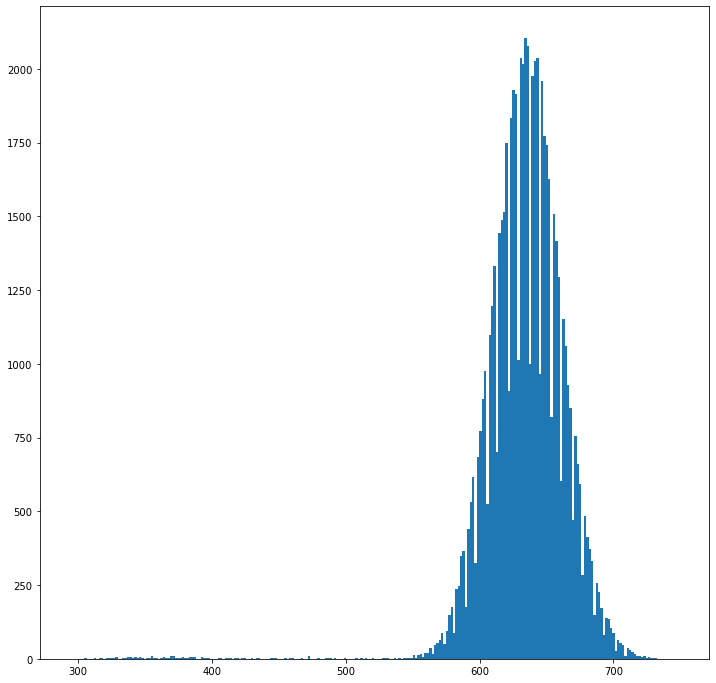

In [3]:
SimulHA=importimagemhd("CIRS015OX/TEST/Dosis-NbOfHits.mhd")
imgIntensityHist(SimulHA)

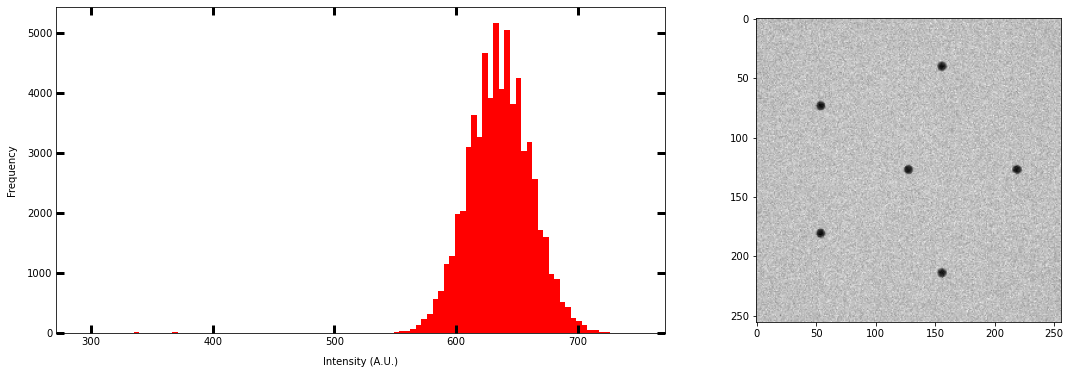

In [4]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})


#plt.scatter(width,Iout)
ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


ax.hist(SimulHA.flatten(),bins=100,color="red")



ax2.imshow(SimulHA,cmap="gray")

In [5]:
ScaledHA=normalize_intensity_map(contrast_stretch(SimulHA))

NegScaledHA=negative(ScaledHA)

claheHA = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
ScaledHA = claheHA.apply(NegScaledHA.astype("uint8"))

294.0 749.0
0.0 256.0
255.0


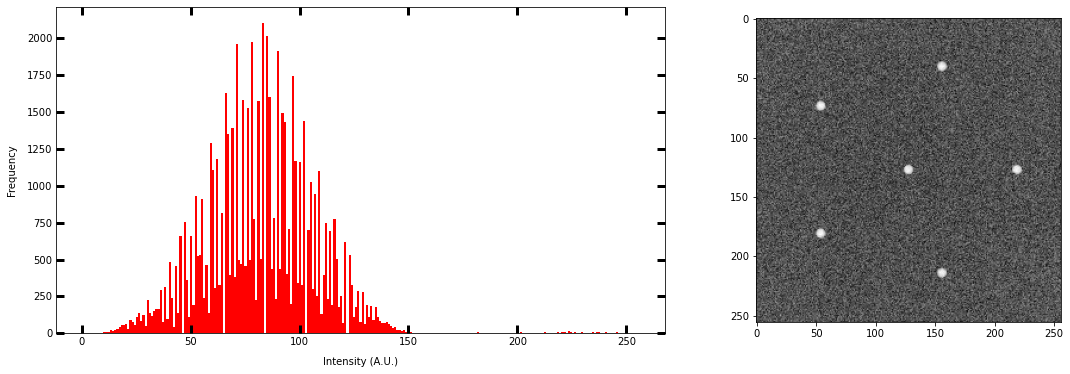

In [6]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


#(smooth(contrast_stretch(scale_intens(image_clahe011)),2)
ax.hist(ScaledHA.flatten(),bins=255,color="red")

ax2.imshow(ScaledHA,cmap="gray")

In [7]:
HA_kuwahara_smooth=scale_intens(kuwahara(ScaledHA,method="gaussian",radius=2))

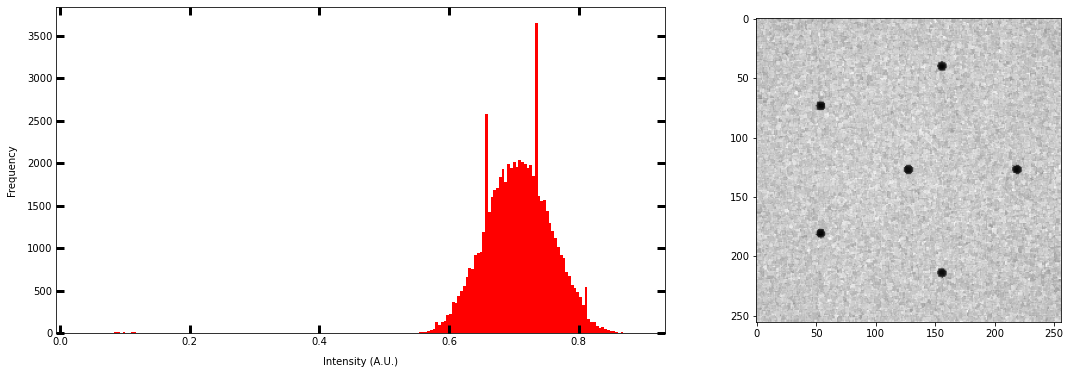

In [8]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})


ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)

ax.hist(HA_kuwahara_smooth.flatten(),bins=200,color="red")

ax2.imshow(HA_kuwahara_smooth,cmap="gray")

In [9]:
HA_more_smoothing=kuwahara(HA_kuwahara_smooth,method="gaussian",radius=1)

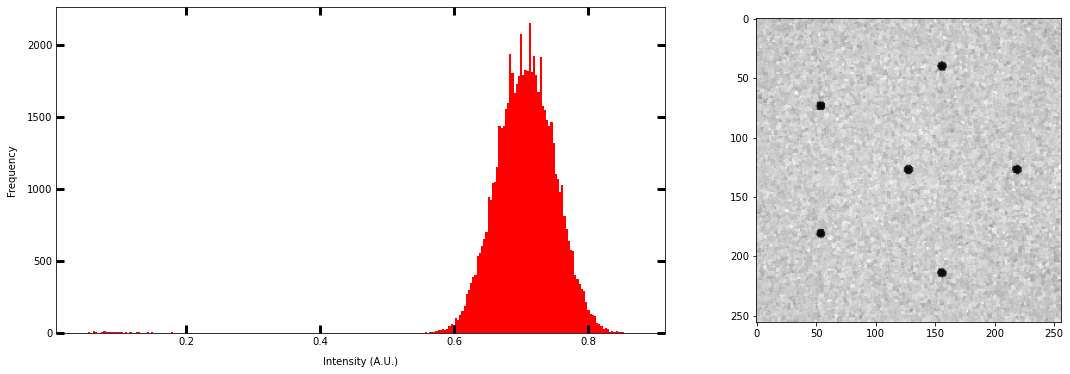

In [10]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


ax.hist(HA_more_smoothing.flatten(),bins=255,color="red")

ax2.imshow(HA_more_smoothing,cmap="gray")

In [11]:
HA_sx = ndimage.sobel(HA_more_smoothing,axis=0)
# Get y-gradient in "sy"
HA_sy = ndimage.sobel(HA_more_smoothing,axis=1)
# Get square root of sum of squares
HA_sobel=np.hypot(HA_sx,HA_sy)


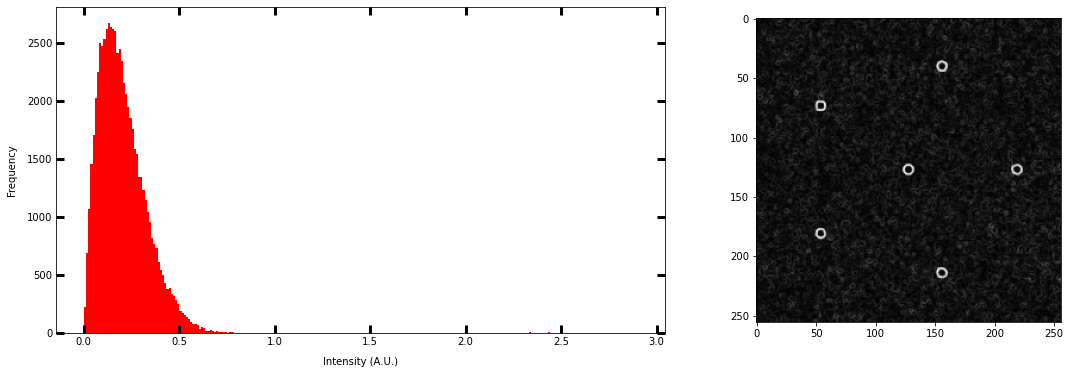

In [12]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


ax.hist(HA_sobel.flatten(),bins=255,color="red")

ax2.imshow(HA_sobel,cmap="gray")

In [13]:
HA_edges=Histogram_cut(normalize_intensity_map(HA_sobel),255*0.2,0)

1.6858739404357614e-07 2.898846441011908


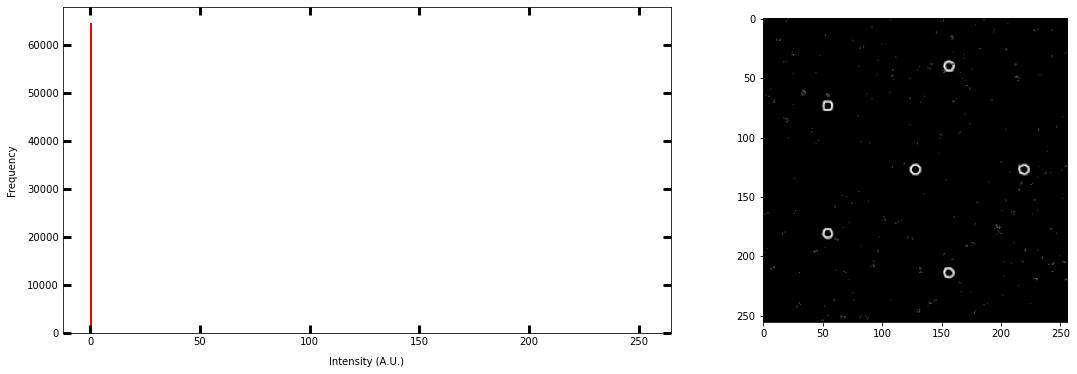

In [14]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)



ax.hist(HA_edges.flatten(),bins=255,color="red")

ax2.imshow(HA_edges,cmap="gray")

In [15]:
FinalImgHA= threshold(HA_edges,255*0.2)

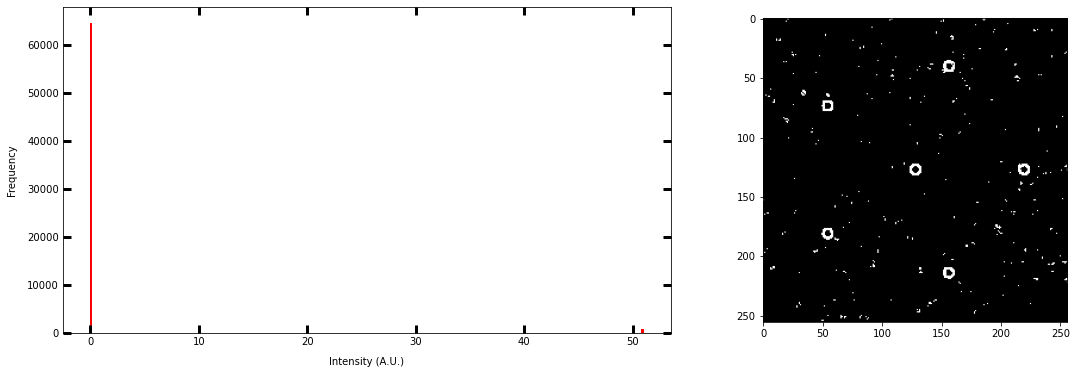

In [16]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.hist(FinalImgHA.flatten(),bins=255,color="red")

ax2.imshow(FinalImgHA,cmap="gray")

In [17]:
HAfixNoise=recolor(FinalImgHA,param1=10,longs=4,intens=2)

256 256


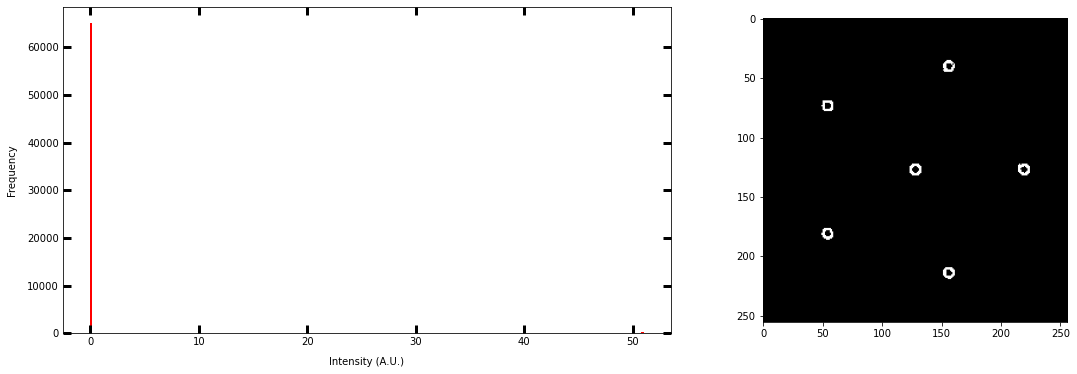

In [18]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.hist(HAfixNoise.flatten(),bins=255,color="red")

ax2.imshow(HAfixNoise*10,cmap="gray")

(-0.5, 255.5, 255.5, -0.5)

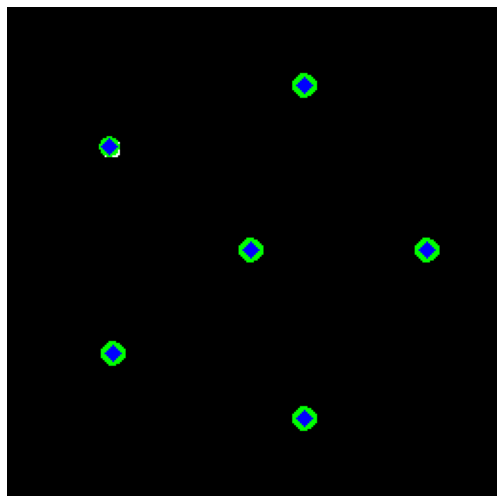

In [19]:
CModelSimHA=circlemodel(HAfixNoise*10,SimulHA,2,60,1,11,3,9)[0]
plt.axis('off')

In [20]:
HAgaugeRad=recalcRad(HAfixNoise*10, CModelSimHA , 15)

In [21]:
ClusterHA=grouping(HAgaugeRad,250)

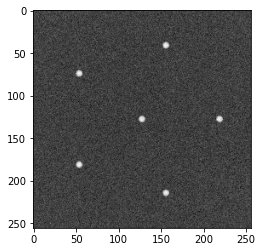

In [22]:
plt.imshow(NegScaledHA,cmap="gray")

In [23]:
SMatrixHA=add_intensityAllNW(NegScaledHA,ClusterHA,1.5)

(6, 8)


In [24]:
SMatrixHA

[array([[ 53.        ,  73.        ,   3.5       , 217.00613839,
          63.70330811, 143.96603954,   5.36981188,  74.3095971 ],
        [127.        , 127.        ,   4.        , 220.94308036,
          62.33631022, 154.93927002,   5.64445488,  67.75976003],
        [155.        ,  41.        ,   3.7       , 225.59151786,
          63.46730358, 163.64397321,   5.43603867,  67.70806249],
        [219.        , 127.        ,   4.        , 223.93136161,
          63.43119013, 163.63952637,   5.67570488,  62.39253993],
        [155.        , 215.        ,   3.6       , 215.63058036,
          63.41561947, 166.26634247,   5.36981188,  63.89906088],
        [ 55.        , 181.        ,   3.9       , 217.57533482,
          63.79980469, 179.96771365,   5.32899556,  58.49908775]])]

In [25]:
df_sim_HA = pd.DataFrame(SMatrixHA[0], columns = ['X','Y','Rad','mean I in', 'mean I out','mean I all','Standard dev','Entropy'])

In [26]:
df_sim_HA

,X,Y,Rad,mean I in,mean I out,mean I all,Standard dev,Entropy
0,53.0,73.0,3.5,217.006138,63.703308,143.966040,5.369812,74.309597
1,127.0,127.0,4.0,220.943080,62.336310,154.939270,5.644455,67.759760
2,155.0,41.0,3.7,225.591518,63.467304,163.643973,5.436039,67.708062
3,219.0,127.0,4.0,223.931362,63.431190,163.639526,5.675705,62.392540
4,155.0,215.0,3.6,215.630580,63.415619,166.266342,5.369812,63.899061
5,55.0,181.0,3.9,217.575335,63.799805,179.967714,5.328996,58.499088


# TRIOXIDO DE ALUMINIO (AT) SIMULACION 200$\mu m$ CIRS015

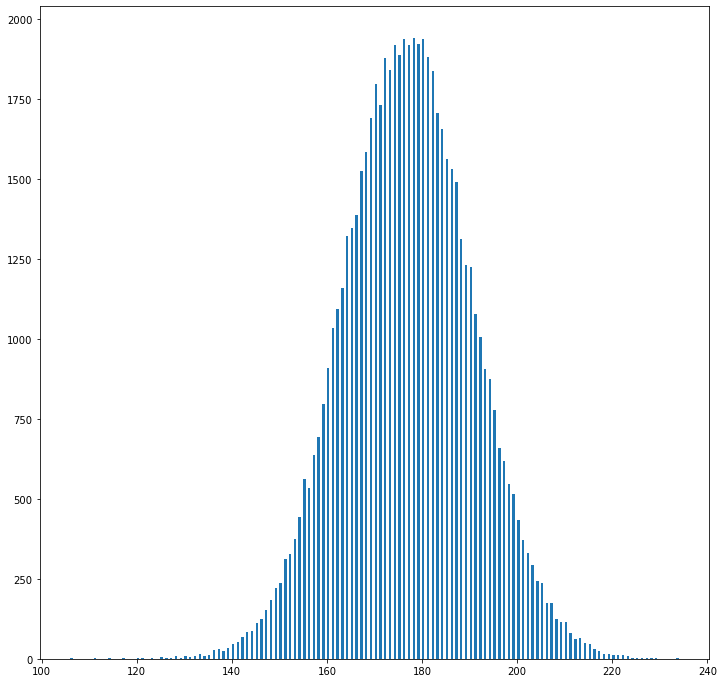

In [27]:
SimulAT=importimagemhd("CIRS015AT/TEST/Dosis-NbOfHits.mhd")
imgIntensityHist(SimulAT)

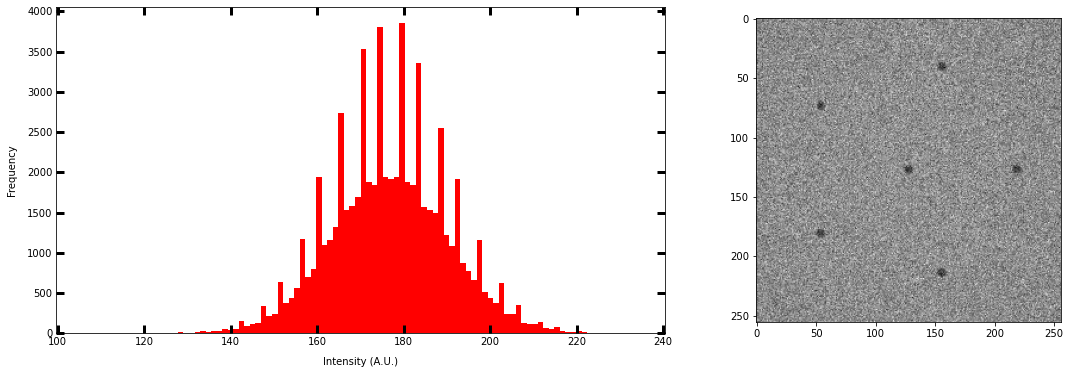

In [28]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})


#plt.scatter(width,Iout)
ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


ax.hist(SimulAT.flatten(),bins=100,color="red")



ax2.imshow(SimulAT,cmap="gray")

In [29]:
ScaledAT=contrast_stretch(normalize_intensity_map(SimulAT))

NegScaledAT=negative(ScaledAT)

claheAT = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
ScaledAT = claheAT.apply(ScaledAT.astype("uint8"))

106.0 234.0
9.9609375 255.0
256.0


10.95703125 255.0


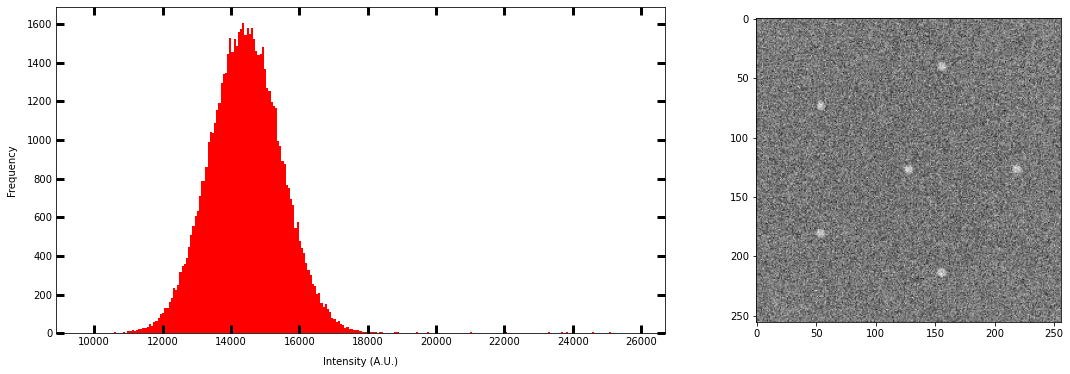

In [30]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


#(smooth(contrast_stretch(scale_intens(image_clahe011)),2)
ax.hist(smooth(contrast_stretch(scale_intens(NegScaledAT)),2).flatten(),bins=255,color="red")

ax2.imshow(NegScaledAT,cmap="gray")

In [31]:
AT_kuwahara_smooth=kuwahara(ScaledAT,method="gaussian",radius=2)

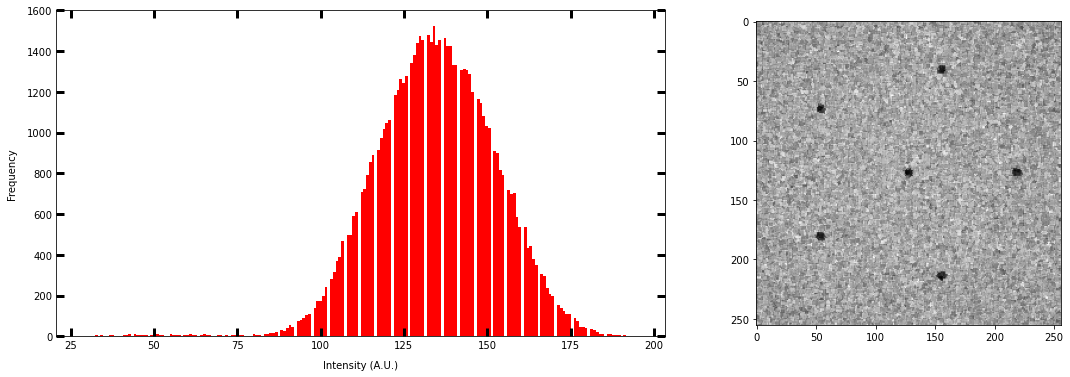

In [32]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})


ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)

ax.hist(AT_kuwahara_smooth.flatten(),bins=200,color="red")

ax2.imshow(AT_kuwahara_smooth,cmap="gray")

In [33]:
AT_more_smoothing=scale_intens(kuwahara(AT_kuwahara_smooth,method="gaussian",radius=4))

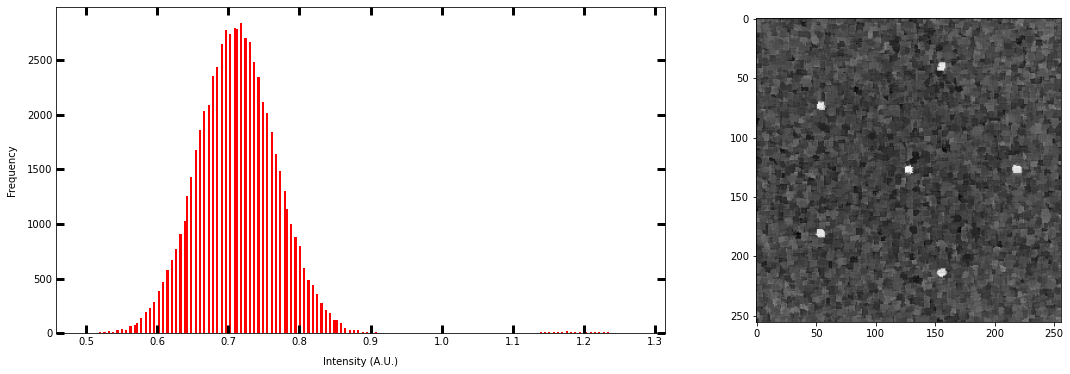

In [34]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


ax.hist(AT_more_smoothing.flatten(),bins=255,color="red")

ax2.imshow(AT_more_smoothing,cmap="gray")

In [35]:
ATsx = ndimage.sobel(AT_more_smoothing,axis=0,mode='constant')
# Get y-gradient in "sy"
ATsy = ndimage.sobel(AT_more_smoothing,axis=1,mode='constant')
# Get square root of sum of squares
ATsobel=np.hypot(ATsx,ATsy)


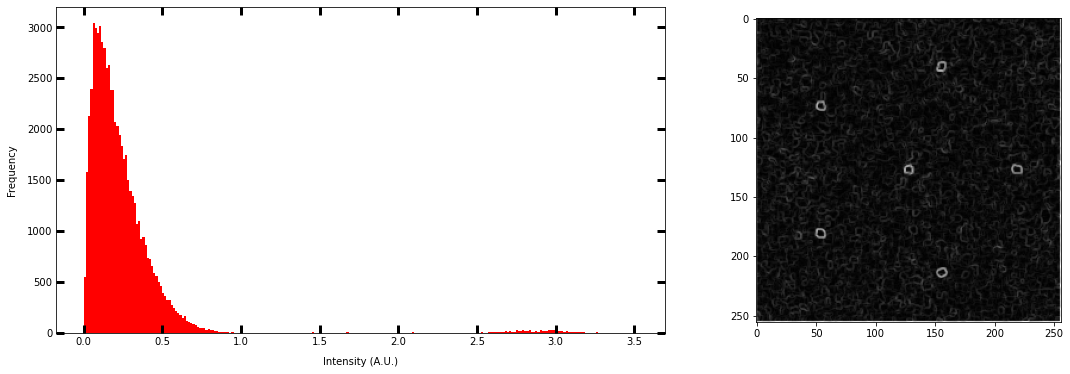

In [36]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


ax.hist(ATsobel.flatten(),bins=255,color="red")

ax2.imshow(ATsobel,cmap="gray")

In [37]:
AT_edges=Histogram_cut(normalize_intensity_map(ATsobel),255*0.2,0)

0.0 3.5199820923465124


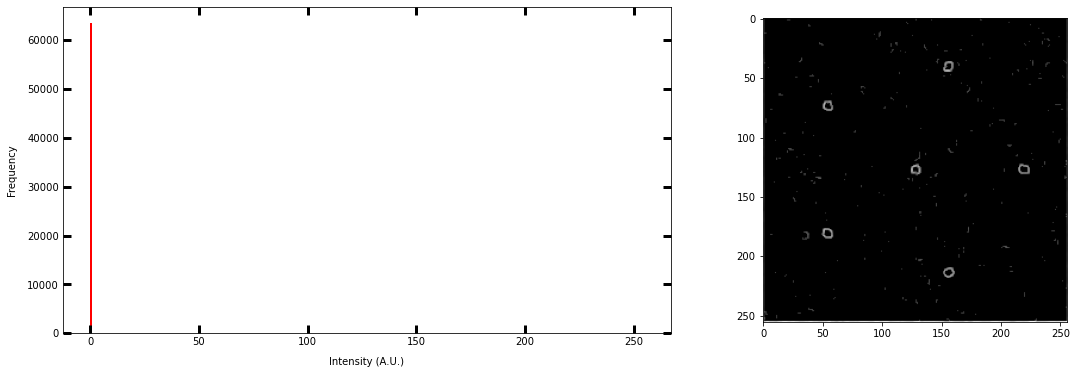

In [38]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)



ax.hist(AT_edges.flatten(),bins=255,color="red")

ax2.imshow(AT_edges,cmap="gray")

In [39]:
FinalImgAT= threshold(AT_edges,255*0.3)

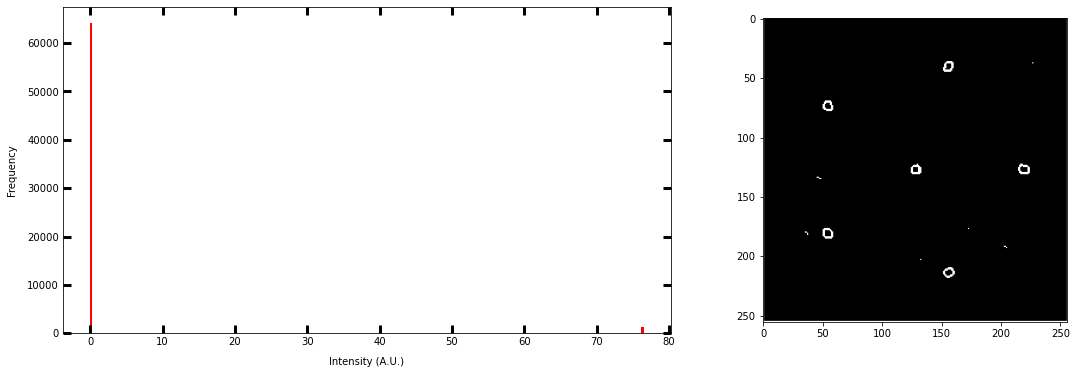

In [40]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.hist(FinalImgAT.flatten(),bins=255,color="red")

ax2.imshow(FinalImgAT,cmap="gray")

In [41]:
ATfixNoise=recolor(FinalImgAT,param1=4,longs=4,intens=1)

256 256


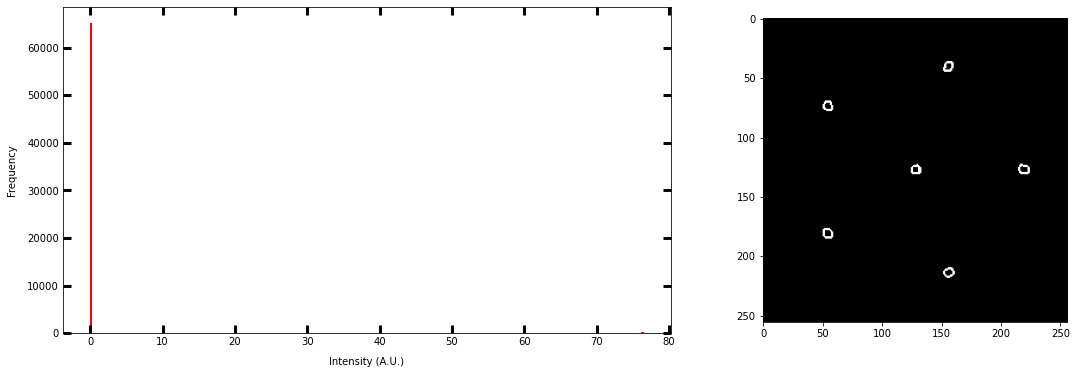

In [42]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.hist(ATfixNoise.flatten(),bins=255,color="red")

ax2.imshow(ATfixNoise*10,cmap="gray")

(-0.5, 255.5, 255.5, -0.5)

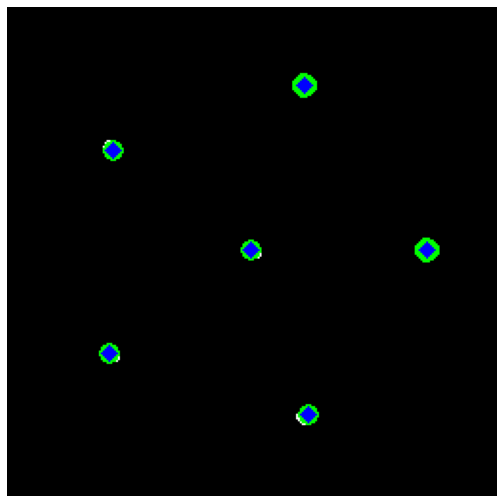

In [43]:
CModelSimAT=circlemodel(ATfixNoise*10,SimulAT,2,50,1,9,3,10)[0]
plt.axis('off')

In [44]:
ATgaugeRad=recalcRad(ATfixNoise*10, CModelSimAT , 1)
ATgaugeRad

array([[154.        ,  41.        ,   4.        ],
       [218.        , 126.        ,   4.25      ],
       [156.        , 213.        ,   3.6       ],
       [ 53.        , 181.        ,   3.71428571],
       [ 54.        ,  74.        ,   4.        ],
       [127.        , 127.        ,   3.57142857]])

In [45]:
ClusterAT=grouping(ATgaugeRad,250)

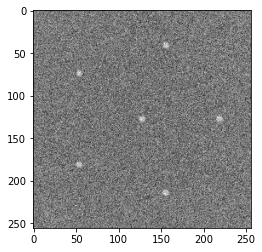

In [46]:
plt.imshow(NegScaledAT,cmap="gray")

In [47]:
SMatrixAT=add_intensityAllNW(NegScaledAT,ClusterAT,1.2)

(6, 8)


In [48]:
SMatrixAT

[array([[154.        ,  41.        ,   4.        , 174.40540541,
         118.3486911 , 155.671875  ,   5.42000913,  42.04278129],
        [218.        , 126.        ,   4.25      , 180.94594595,
         118.781     , 153.7037037 ,   5.55251127,  41.28385463],
        [156.        , 213.        ,   3.6       , 188.48      ,
         119.03555556, 166.18367347,   5.15032438,  38.62729999],
        [ 53.        , 181.        ,   3.71428571, 186.10344828,
         118.74222222, 159.34693878,   5.02247413,  42.88787042],
        [ 54.        ,  74.        ,   4.        , 183.91891892,
         118.27225131, 159.34375   ,   5.21461465,  40.97644855],
        [127.        , 127.        ,   3.57142857, 191.76      ,
         116.25333333, 164.53061224,   5.06329046,  40.2736061 ]])]

In [49]:
df_sim_AT = pd.DataFrame(SMatrixAT[0], columns = ['X','Y','Rad','mean I in', 'mean I out','mean I all','Standard dev','Entropy'])

In [50]:
df_sim_AT

,X,Y,Rad,mean I in,mean I out,mean I all,Standard dev,Entropy
0,154.0,41.0,4.000000,174.405405,118.348691,155.671875,5.420009,42.042781
1,218.0,126.0,4.250000,180.945946,118.781000,153.703704,5.552511,41.283855
2,156.0,213.0,3.600000,188.480000,119.035556,166.183673,5.150324,38.627300
3,53.0,181.0,3.714286,186.103448,118.742222,159.346939,5.022474,42.887870
4,54.0,74.0,4.000000,183.918919,118.272251,159.343750,5.214615,40.976449
5,127.0,127.0,3.571429,191.760000,116.253333,164.530612,5.063290,40.273606


In [51]:
import math
from scipy import ndimage
import seaborn as sns
import matplotlib.pyplot as plt

flatfield=importimagemhd("lastsims/FlatField/Dosis-NbOfHits.mhd")[128:128*3].T[128:128*3].T
testfinal=(importimagemhd("images_dimdetectorHA/Dosis-NbOfHits.mhd"))

this_testfinal2=testfinal/flatfield

#GRAPH FORMAT
import matplotlib as mpl
from pylab import cm

import matplotlib.font_manager as fm
# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
#print(font_names)
colors = cm.get_cmap('tab10', 2)
# Rebuild the matplotlib font cache
fm._rebuild()

mpl.rcParams['font.family'] = 'Garamond'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

from scipy.interpolate import interp2d

def interpolate_pixels(image):
    """
    Clear dead and hot pixels in an image by interpolation.
    
    Args:
        image (ndarray): A numpy array representing an image.
        
    Returns:
        A numpy array with dead and hot pixels interpolated.
    """
    
    # Find dead and hot pixels (pixels with zero or maximum intensity)
    dead_pixels = np.where(image == 0)
    hot_pixels = np.where(image == np.max(image))
    print(dead_pixels)
    #print(hot_pixels)
    # Create a copy of the original image to interpolate on
    image_copy = np.copy(image)
    
    # Interpolate dead pixels
    for i in range(len(dead_pixels[0])):
        x, y = dead_pixels[0][i], dead_pixels[1][i]
        if x > 0 and y > 0 and x < image.shape[0]-1 and y < image.shape[1]-1:
            image_copy[x, y] = np.mean([image[x+1, y], image[x-1, y], image[x, y+1], image[x, y-1]])
    
     #Interpolate hot pixels
    for i in range(len(hot_pixels[0])):
        x, y = hot_pixels[0][i], hot_pixels[1][i]
        if x > 0 and y > 0 and x < image.shape[0]-1 and y < image.shape[1]-1:
            # Create a 2D interpolation function for the surrounding pixels
            x_points = [x-1, x+1, x, x]
            y_points = [y, y, y-1, y+1]
            z_points = [image[x-1, y], image[x+1, y], image[x, y-1], image[x, y+1]]
            interp_func = np.mean([image[x+1, y], image[x-1, y], image[x, y+1], image[x, y-1]])
            
            # Interpolate the hot pixel value
            image_copy[x, y] = interp_func
    
    return image_copy

(array([], dtype=int64), array([], dtype=int64))


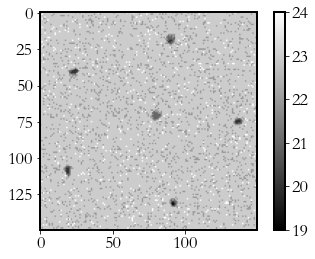

In [52]:
REAL=cv2.imread("ImagenesHUSIDavidJurado/01b. CIRS015 - SM Reference - R.bmp",0)
#plt.figure(figsize=(20,10))
plt.imshow(REAL,cmap="gray")

plt.imshow(REAL[1765:1915,805:955],cmap="gray")
plt.colorbar()
frac=interpolate_pixels(REAL[1100:2300,200:1200])

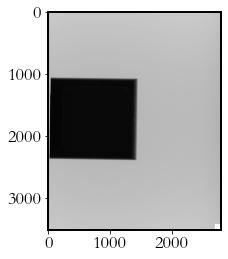

In [53]:
plt.imshow(REAL,cmap="gray")


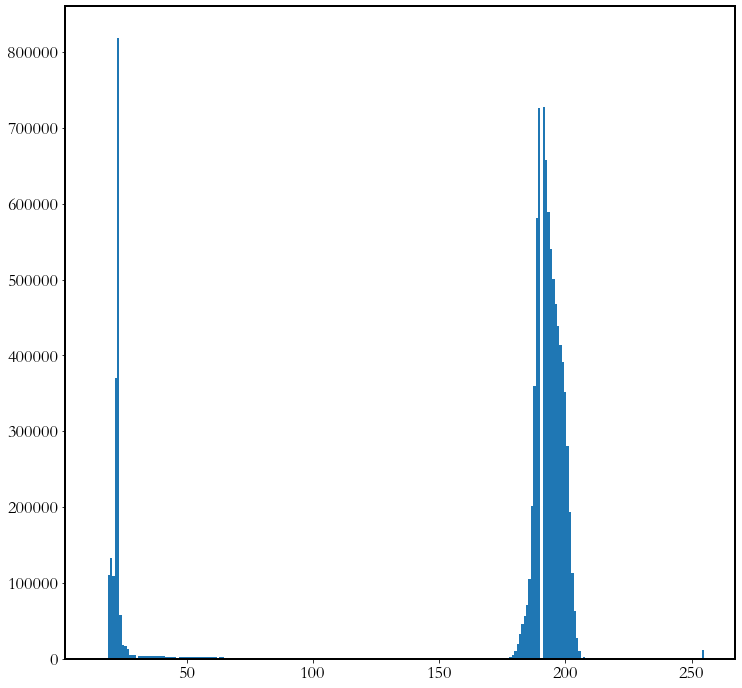

In [146]:
#frac=cv2.resize(frac,dsize=None,fx=1.35,fy=1.35,interpolation = cv2.INTER_AREA)
imgIntensityHist(REAL)

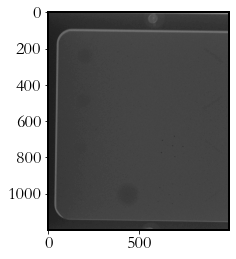

In [55]:
plt.imshow(frac,cmap="gray")

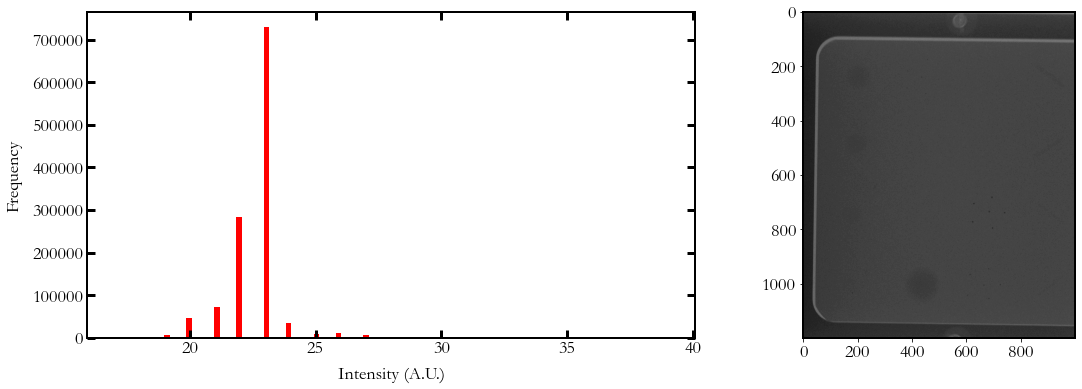

In [56]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})


#plt.scatter(width,Iout)
ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


ax.hist(frac.flatten(),bins=100,color="red")



ax2.imshow(frac,cmap="gray")

In [57]:
ScaledReal=normalize_intensity_map(contrast_stretch(frac))

NSReal=negative(ScaledReal[670:815,610:755])
NSReal=cv2.resize(NSReal,dsize=None,fx=1.35,fy=1.35,interpolation = cv2.INTER_AREA)

NSReal=normalize_intensity_map(contrast_stretch(NSReal))

claheR = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
enhR = claheR.apply(NSReal.astype("uint8"))

17 39
0.0 256.0
80.68359375
0.05976565349847418 56.02031206777319
0.0 256.0


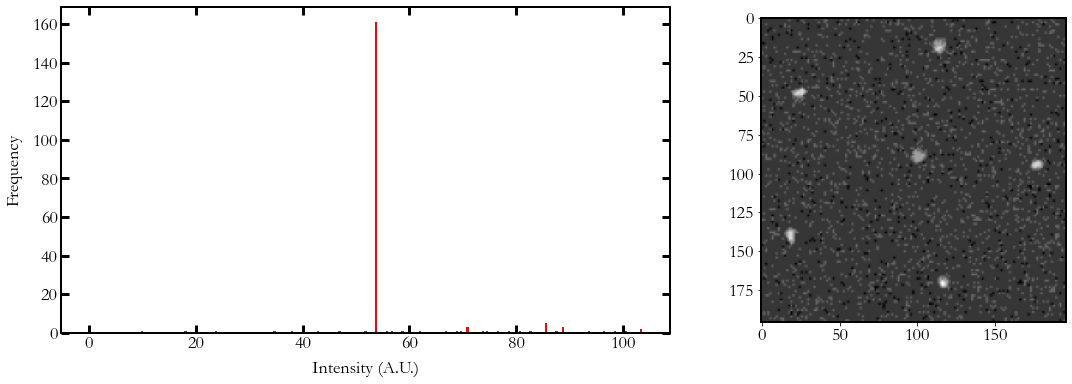

In [145]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


#(smooth(contrast_stretch(scale_intens(image_clahe011)),2)
ax.hist(NSReal.flatten()[52:255],bins=255,color="red")

ax2.imshow(NSReal,cmap="gray")

In [59]:
real_smooth=kuwahara(enhR,method="gaussian",radius=2)

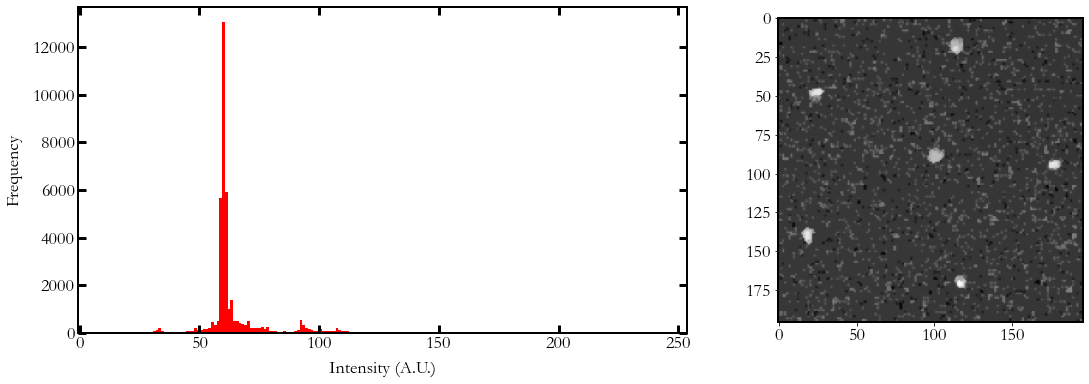

In [60]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})


ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)

ax.hist(real_smooth.flatten(),bins=200,color="red")

ax2.imshow(real_smooth,cmap="gray")

In [61]:
second_layer=scale_intens(kuwahara(real_smooth,method="gaussian",radius=4))

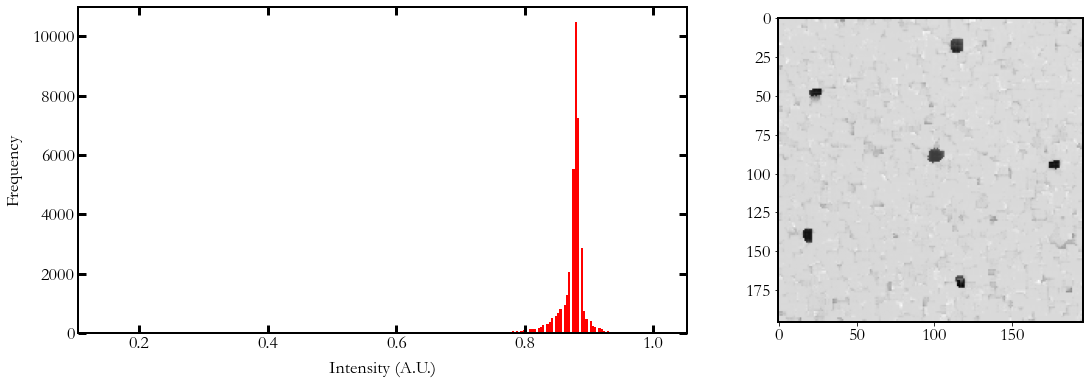

In [62]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


ax.hist(second_layer.flatten(),bins=255,color="red")

ax2.imshow(second_layer,cmap="gray")

In [63]:
rsx = ndimage.sobel(second_layer,axis=0,mode='constant')
# Get y-gradient in "sy"
rsy = ndimage.sobel(second_layer,axis=1,mode='constant')
# Get square root of sum of squares
real_sobel=np.hypot(rsx,rsy)


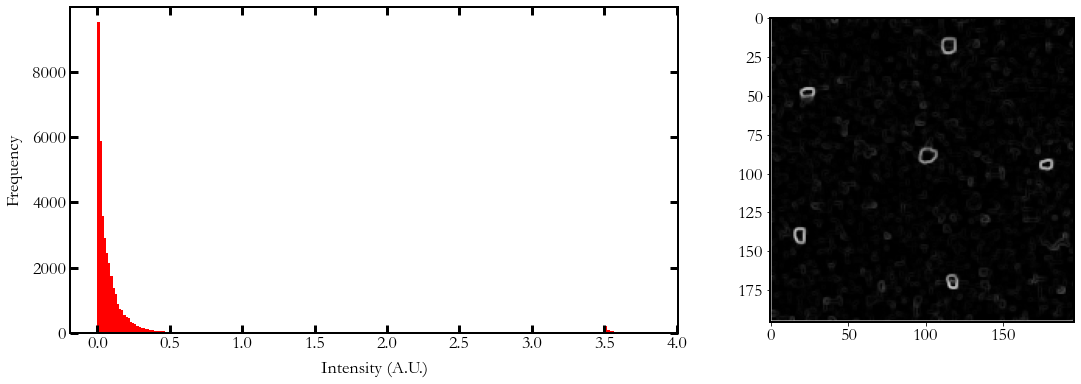

In [64]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)


ax.hist(real_sobel.flatten(),bins=255,color="red")

ax2.imshow(real_sobel,cmap="gray")

In [65]:
real_th=Histogram_cut(normalize_intensity_map(real_sobel),255*0.1,0)

0.0 3.8208909570629266


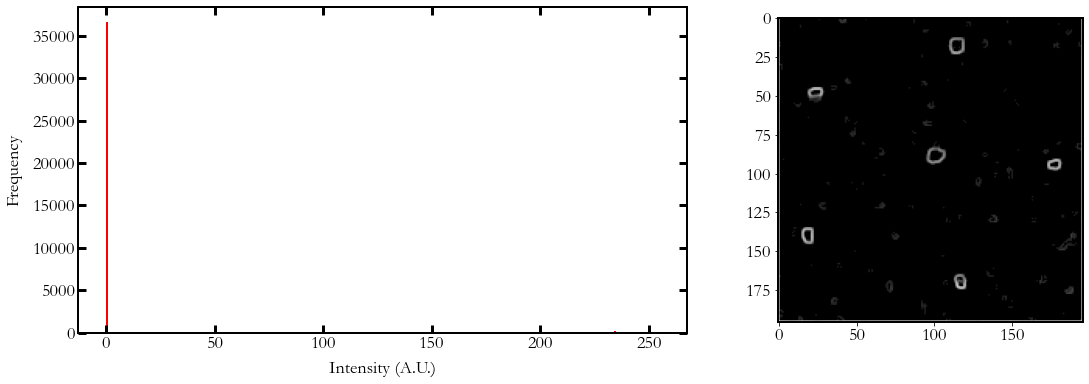

In [66]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)



ax.hist(real_th.flatten(),bins=255,color="red")

ax2.imshow(real_th,cmap="gray")

In [67]:
real_final= threshold(real_th,255*0.2)

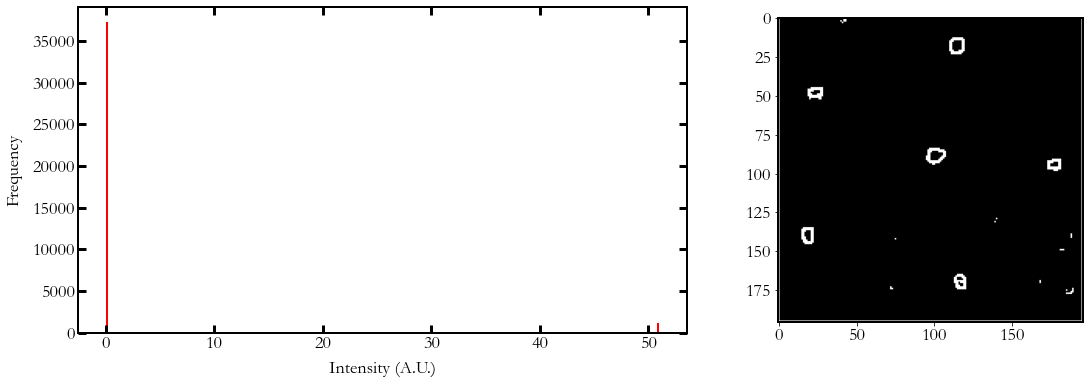

In [68]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.hist(real_final.flatten(),bins=255,color="red")

ax2.imshow(real_final,cmap="gray")

In [69]:
real_recolor=recolor(real_final,param1=4,longs=4,intens=2)

196 196


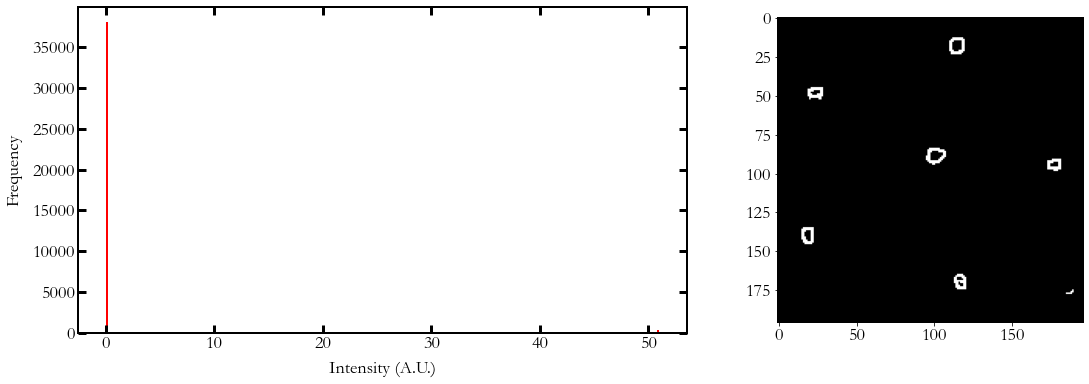

In [70]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.xaxis.set_tick_params(which='major', size=8, width=3, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=3, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=3, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=3, direction='in', right='on')
ax.set_xlabel('Intensity (A.U.)', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.hist(real_recolor.flatten(),bins=255,color="red")

ax2.imshow(real_recolor*10,cmap="gray")

(-0.5, 195.5, 195.5, -0.5)

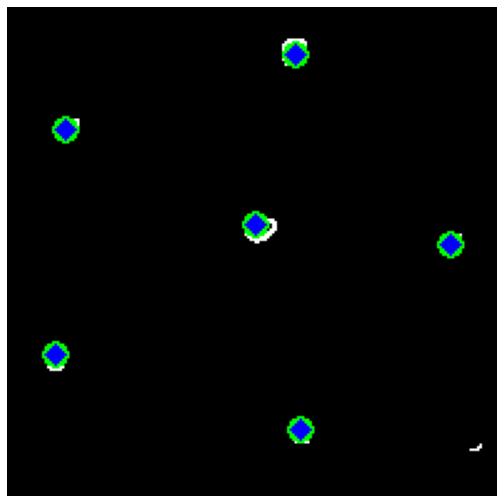

In [71]:
Real_Cmod=circlemodel(real_recolor*10,REAL,2,50,100,11,2,5)[0]
plt.axis('off')

In [72]:
RealFeat=recalcRad(real_recolor*10, Real_Cmod , 1)

In [73]:
RealFeat

array([[ 99.        ,  88.        ,   3.66666667],
       [116.        , 169.        ,   3.71428571],
       [177.        ,  94.        ,   3.42857143],
       [ 23.        ,  49.        ,   3.71428571],
       [114.        ,  18.        ,   4.        ],
       [ 18.        , 139.        ,   3.66666667]])

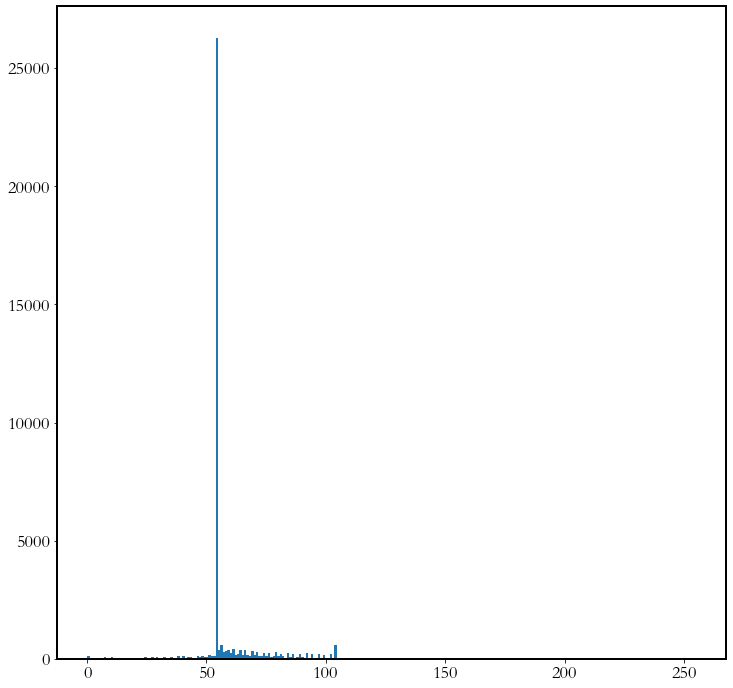

In [74]:
imgIntensityHist(NSReal)

In [75]:
GroupReal=grouping(RealFeat,250)

In [150]:
RMatrix=add_intensityAllNW(NSReal,GroupReal,1.1)

(6, 8)


In [151]:
RMatrix

[array([[ 18.        , 139.        ,   3.66666667, 162.30943834,
          57.74954131, 129.1669324 ,   4.18073714,  56.51492398],
        [ 99.        ,  88.        ,   3.66666667, 137.59554476,
          60.62588778, 112.47727997,   3.62642572,  40.28439053],
        [116.        , 169.        ,   3.71428571, 153.99070946,
          57.1307558 , 116.80723852,   4.21939599,  60.20976916],
        [177.        ,  94.        ,   3.42857143, 173.62944504,
          58.67692957, 134.49298469,   4.41615768,  58.70713108],
        [ 23.        ,  49.        ,   3.71428571, 154.85219595,
          58.89026989, 126.82916135,   4.47356399,  54.99391519],
        [114.        ,  18.        ,   4.        , 155.74479167,
          58.15097959, 137.04071045,   5.03063906,  37.23870735]])]

In [152]:
np.max(NSReal)

255.0

In [153]:
df_real_AT= pd.DataFrame(RMatrix[0], columns = ['X','Y','Rad','mean I in', 'mean I out','mean I all','Standard dev','Entropy'])

In [154]:
dfreal_vs_sim_AT=pd.concat([df_real_AT,df_sim_AT],ignore_index=True)

In [155]:
df_real_AT

,X,Y,Rad,mean I in,mean I out,mean I all,Standard dev,Entropy
0,18.0,139.0,3.666667,162.309438,57.749541,129.166932,4.180737,56.514924
1,99.0,88.0,3.666667,137.595545,60.625888,112.477280,3.626426,40.284391
2,116.0,169.0,3.714286,153.990709,57.130756,116.807239,4.219396,60.209769
3,177.0,94.0,3.428571,173.629445,58.676930,134.492985,4.416158,58.707131
4,23.0,49.0,3.714286,154.852196,58.890270,126.829161,4.473564,54.993915
5,114.0,18.0,4.000000,155.744792,58.150980,137.040710,5.030639,37.238707


In [156]:
dfreal_vs_sim_AT["CNR"]=(dfreal_vs_sim_AT["mean I in"]-dfreal_vs_sim_AT["mean I out"])/dfreal_vs_sim_AT["Standard dev"]
dfreal_vs_sim_AT["Dif"]=dfreal_vs_sim_AT["mean I in"]-dfreal_vs_sim_AT["mean I out"]

dfreal_vs_sim_AT["Dif"]=dfreal_vs_sim_AT["mean I in"]-dfreal_vs_sim_AT["mean I out"]

dfreal_vs_sim_AT["Mean Intensity Normalized In"]=np.abs(dfreal_vs_sim_AT["mean I in"]-dfreal_vs_sim_AT["mean I out"])/dfreal_vs_sim_AT["Standard dev"]

dfreal_vs_sim_AT["Mean Intensity Normalized Out"]=np.abs(dfreal_vs_sim_AT["mean I out"]-np.mean(dfreal_vs_sim_AT["mean I out"]))/dfreal_vs_sim_AT["Standard dev"]


dfreal_vs_sim_AT

,X,Y,Rad,mean I in,mean I out,mean I all,Standard dev,Entropy,CNR,Dif,Mean Intensity Normalized In,Mean Intensity Normalized Out
0,18.0,139.0,3.666667,162.309438,57.749541,129.166932,4.180737,56.514924,25.009919,104.559897,25.009919,7.328511
1,99.0,88.0,3.666667,137.595545,60.625888,112.477280,3.626426,40.284391,21.224661,76.969657,21.224661,7.655535
2,116.0,169.0,3.714286,153.990709,57.130756,116.807239,4.219396,60.209769,22.955881,96.859954,22.955881,7.408018
3,177.0,94.0,3.428571,173.629445,58.676930,134.492985,4.416158,58.707131,26.029984,114.952515,26.029984,6.727837
4,23.0,49.0,3.714286,154.852196,58.890270,126.829161,4.473564,54.993915,21.450889,95.961926,21.450889,6.593814
5,114.0,18.0,4.000000,155.744792,58.150980,137.040710,5.030639,37.238707,19.399884,97.593812,19.399884,6.010596
6,154.0,41.0,4.000000,174.405405,118.348691,155.671875,5.420009,42.042781,10.342550,56.056714,10.342550,5.527772
7,218.0,126.0,4.250000,180.945946,118.781000,153.703704,5.552511,41.283855,11.195825,62.164946,11.195825,5.473718
8,156.0,213.0,3.600000,188.480000,119.035556,166.183673,5.150324,38.627300,13.483509,69.444444,13.483509,5.950584
9,53.0,181.0,3.714286,186.103448,118.742222,159.346939,5.022474,42.887870,13.411961,67.361226,13.411961,6.043656


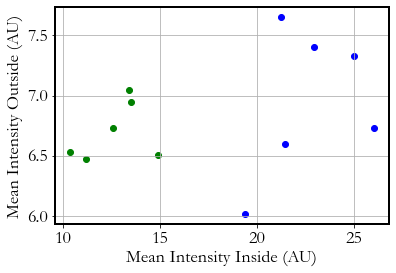

In [164]:
plt.scatter(dfreal_vs_sim_AT["Mean Intensity Normalized In"][0:6] ,dfreal_vs_sim_AT["Mean Intensity Normalized Out"][0:6]  ,color="Blue")
plt.scatter(dfreal_vs_sim_AT["Mean Intensity Normalized In"][6:12],dfreal_vs_sim_AT["Mean Intensity Normalized Out"][6:12]+1,color="Green"  )
#plt.scatter(dfreal_vs_sim_AT["mean I in"][12:17],dfreal_vs_sim_AT["mean I out"][12:17],color="Blue"  )
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][0:6],y=dfreal_vs_sim_AT["mean I out"][0:6]   ,xerr=1.8,marker="o", fmt="none",yerr=0.16,color="Green",capsize=5)
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][6:12],y=dfreal_vs_sim_AT["mean I out"][6:12] ,xerr=2.4,marker="o", fmt="none",yerr=3.16  ,color="Red"  ,capsize=5)

plt.xlabel("Mean Intensity Inside (AU)")
plt.ylabel("Mean Intensity Outside (AU)")
plt.grid()

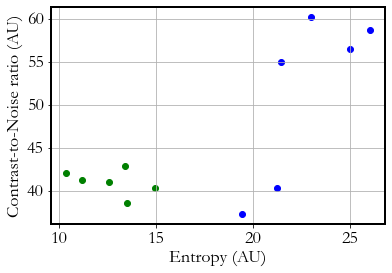

In [160]:
plt.scatter(dfreal_vs_sim_AT["CNR"][0:6], dfreal_vs_sim_AT["Entropy"][0:6]  ,color="Blue")
plt.scatter(dfreal_vs_sim_AT["CNR"][6:12],dfreal_vs_sim_AT["Entropy"][6:12],color="Green"  )
#plt.scatter(dfreal_vs_sim_AT["mean I in"][12:17],dfreal_vs_sim_AT["mean I out"][12:17],color="Blue"  )
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][0:6],y=dfreal_vs_sim_AT["mean I out"][0:6]   ,xerr=1.8,marker="o", fmt="none",yerr=0.16,color="Green",capsize=5)
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][6:12],y=dfreal_vs_sim_AT["mean I out"][6:12] ,xerr=2.4,marker="o", fmt="none",yerr=3.16  ,color="Red"  ,capsize=5)

plt.xlabel("Entropy (AU)")
plt.ylabel("Contrast-to-Noise ratio (AU)")
plt.grid()

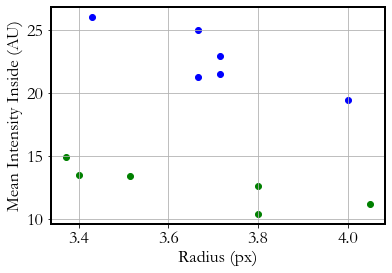

In [163]:
plt.scatter(dfreal_vs_sim_AT["Rad"][0:6], dfreal_vs_sim_AT["Mean Intensity Normalized In"][0:6]  ,color="Blue")
plt.scatter(dfreal_vs_sim_AT["Rad"][6:12]-0.2,dfreal_vs_sim_AT["Mean Intensity Normalized In"][6:12],color="Green"  )
#plt.scatter(dfreal_vs_sim_AT["mean I in"][12:17],dfreal_vs_sim_AT["mean I out"][12:17],color="Blue"  )
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][0:6],y=dfreal_vs_sim_AT["mean I out"][0:6]   ,xerr=1.8,marker="o", fmt="none",yerr=0.16,color="Green",capsize=5)
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][6:12],y=dfreal_vs_sim_AT["mean I out"][6:12] ,xerr=2.4,marker="o", fmt="none",yerr=3.16  ,color="Red"  ,capsize=5)

plt.xlabel("Radius (px)")
plt.ylabel("Mean Intensity Inside (AU)")
plt.grid()

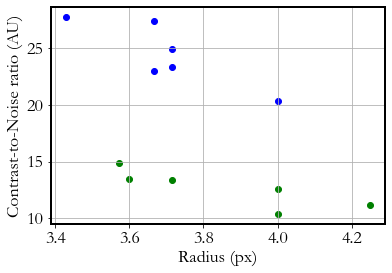

In [136]:
plt.scatter(dfreal_vs_sim_AT["Rad"][0:6], dfreal_vs_sim_AT["CNR"][0:6]  ,color="Blue")
plt.scatter(dfreal_vs_sim_AT["Rad"][6:12],dfreal_vs_sim_AT["CNR"][6:12],color="Green"  )
#plt.scatter(dfreal_vs_sim_AT["mean I in"][12:17],dfreal_vs_sim_AT["mean I out"][12:17],color="Blue"  )
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][0:6],y=dfreal_vs_sim_AT["mean I out"][0:6]   ,xerr=1.8,marker="o", fmt="none",yerr=0.16,color="Green",capsize=5)
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][6:12],y=dfreal_vs_sim_AT["mean I out"][6:12] ,xerr=2.4,marker="o", fmt="none",yerr=3.16  ,color="Red"  ,capsize=5)

plt.xlabel("Radius (px)")
plt.ylabel("Contrast-to-Noise ratio (AU)")
plt.grid()

In [137]:
dfbenign_vs_malign=pd.concat([df_sim_AT,df_sim_HA],ignore_index=True)

In [138]:
dfbenign_vs_malign["CNR"]=(dfbenign_vs_malign["mean I in"]-dfbenign_vs_malign["mean I out"])/dfbenign_vs_malign["Standard dev"]

dfbenign_vs_malign["Dif"]=dfbenign_vs_malign["mean I in"]-dfbenign_vs_malign["mean I out"]

dfbenign_vs_malign["Mean Intensity Normalized In"]=np.abs(dfbenign_vs_malign["mean I in"]-dfbenign_vs_malign["mean I out"])/dfbenign_vs_malign["Standard dev"]

dfbenign_vs_malign["Mean Intensity Normalized Out"]=np.abs(dfbenign_vs_malign["mean I out"]-np.mean(dfbenign_vs_malign["mean I out"]))/dfbenign_vs_malign["Standard dev"]

dfbenign_vs_malign

,X,Y,Rad,mean I in,mean I out,mean I all,Standard dev,Entropy,CNR,Dif,Mean Intensity Normalized In,Mean Intensity Normalized Out
0,154.0,41.0,4.000000,174.405405,118.348691,155.671875,5.420009,42.042781,10.342550,56.056714,10.342550,5.082982
1,218.0,126.0,4.250000,180.945946,118.781000,153.703704,5.552511,41.283855,11.195825,62.164946,11.195825,5.039543
2,156.0,213.0,3.600000,188.480000,119.035556,166.183673,5.150324,38.627300,13.483509,69.444444,13.483509,5.482504
3,53.0,181.0,3.714286,186.103448,118.742222,159.346939,5.022474,42.887870,13.411961,67.361226,13.411961,5.563660
4,54.0,74.0,4.000000,183.918919,118.272251,159.343750,5.214615,40.976449,12.588978,65.646668,12.588978,5.268533
5,127.0,127.0,3.571429,191.760000,116.253333,164.530612,5.063290,40.273606,14.912569,75.506667,14.912569,5.027255
6,53.0,73.0,3.500000,217.006138,63.703308,143.966040,5.369812,74.309597,28.549013,153.302830,28.549013,5.045908
7,127.0,127.0,4.000000,220.943080,62.336310,154.939270,5.644455,67.759760,28.099573,158.606770,28.099573,5.042572
8,155.0,41.0,3.700000,225.591518,63.467304,163.643973,5.436039,67.708062,29.823963,162.124214,29.823963,5.027849
9,219.0,127.0,4.000000,223.931362,63.431190,163.639526,5.675705,62.392540,28.278456,160.500171,28.278456,4.821902


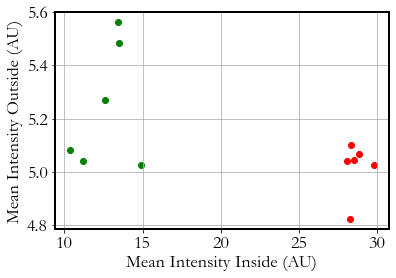

In [165]:
plt.scatter(dfbenign_vs_malign["Mean Intensity Normalized In"][0:6], dfbenign_vs_malign["Mean Intensity Normalized Out"][0:6]  ,color="Green")
plt.scatter(dfbenign_vs_malign["Mean Intensity Normalized In"][6:12],dfbenign_vs_malign["Mean Intensity Normalized Out"][6:12],color="Red"  )
#plt.scatter(dfreal_vs_sim_AT["mean I in"][12:17],dfreal_vs_sim_AT["mean I out"][12:17],color="Blue"  )
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][0:6],y=dfreal_vs_sim_AT["mean I out"][0:6]   ,xerr=1.8,marker="o", fmt="none",yerr=0.16,color="Green",capsize=5)
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][6:12],y=dfreal_vs_sim_AT["mean I out"][6:12] ,xerr=2.4,marker="o", fmt="none",yerr=3.16  ,color="Red"  ,capsize=5)

plt.xlabel("Mean Intensity Inside (AU)")
plt.ylabel("Mean Intensity Outside (AU)")
plt.grid()

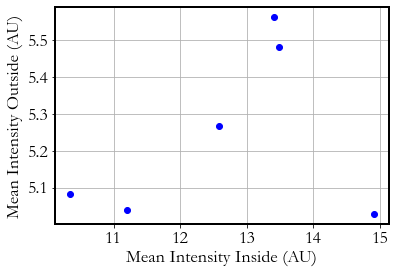

In [140]:
plt.scatter(dfbenign_vs_malign["Mean Intensity Normalized In"][0:6], dfbenign_vs_malign["Mean Intensity Normalized Out"][0:6]  ,color="Blue")
plt.xlabel("Mean Intensity Inside (AU)")
plt.ylabel("Mean Intensity Outside (AU)")
plt.grid()

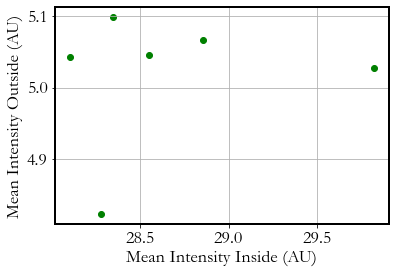

In [141]:
plt.scatter(dfbenign_vs_malign["Mean Intensity Normalized In"][6:12],dfbenign_vs_malign["Mean Intensity Normalized Out"][6:12],color="Green"  )
plt.xlabel("Mean Intensity Inside (AU)")
plt.ylabel("Mean Intensity Outside (AU)")
plt.grid()

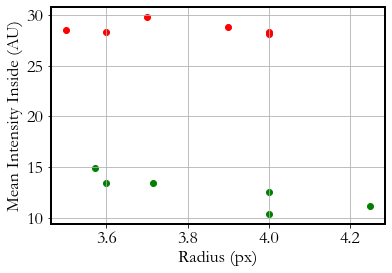

In [166]:
plt.scatter(dfbenign_vs_malign["Rad"][0:6], dfbenign_vs_malign["Mean Intensity Normalized In"][0:6]  ,color="Green")
plt.scatter(dfbenign_vs_malign["Rad"][6:12],dfbenign_vs_malign["Mean Intensity Normalized In"][6:12],color="Red"  )
#plt.scatter(dfreal_vs_sim_AT["mean I in"][12:17],dfreal_vs_sim_AT["mean I out"][12:17],color="Blue"  )
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][0:6],y=dfreal_vs_sim_AT["mean I out"][0:6]   ,xerr=1.8,marker="o", fmt="none",yerr=0.16,color="Green",capsize=5)
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][6:12],y=dfreal_vs_sim_AT["mean I out"][6:12] ,xerr=2.4,marker="o", fmt="none",yerr=3.16  ,color="Red"  ,capsize=5)

plt.xlabel("Radius (px)")
plt.ylabel("Mean Intensity Inside (AU)")
plt.grid()

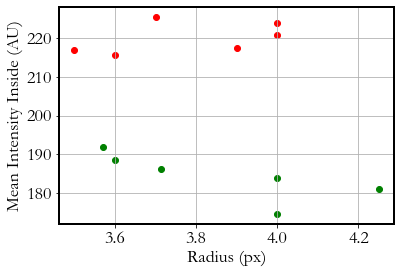

In [168]:
plt.scatter(dfbenign_vs_malign["Rad"][0:6], dfbenign_vs_malign["mean I in"][0:6]  ,color="Green")
plt.scatter(dfbenign_vs_malign["Rad"][6:12],dfbenign_vs_malign["mean I in"][6:12],color="Red"  )
#plt.scatter(dfreal_vs_sim_AT["mean I in"][12:17],dfreal_vs_sim_AT["mean I out"][12:17],color="Blue"  )
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][0:6],y=dfreal_vs_sim_AT["mean I out"][0:6]   ,xerr=1.8,marker="o", fmt="none",yerr=0.16,color="Green",capsize=5)
#plt.errorbar(x=dfreal_vs_sim_AT["mean I in"][6:12],y=dfreal_vs_sim_AT["mean I out"][6:12] ,xerr=2.4,marker="o", fmt="none",yerr=3.16  ,color="Red"  ,capsize=5)

plt.xlabel("Radius (px)")
plt.ylabel("Mean Intensity Inside (AU)")
plt.grid()